In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import StringIndexer
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.functions import *
from pyspark.sql.functions import col, udf, month, hour
from pyspark.mllib.stat import Statistics
from pyspark.sql.types import IntegerType, DoubleType, BooleanType, StringType, TimestampType
spark = SparkSession.Builder().appName('DDAM_Project_South').getOrCreate()
sqlCtx = SQLContext(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/13 21:21:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/12/13 21:21:40 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [2]:
df=spark.read.csv("../../Datasets/South_Incidents.csv", header=True, inferSchema=True, sep=",")

In [3]:
df=df.drop('ID')

In [4]:
# Remove not interesting variables
to_delete=['Source','Country','Weather_TimeStamp','End_Time','Sunrise_Sunset','Civil_Twilight','Nautical_Twilight','End_Lat','End_Lng','Description','Timezone','Street','Zipcode','Airport_Code']
for col in to_delete:
    df = df.drop(col)

# VARIABLES EXPLORATION

In [13]:
summary = df.describe().toPandas().T
summary

0                     1                    2  \
summary                 count                  mean               stddev   
Severity               172550    2.0703042596348884   0.3972252120724316   
Start_Lat              172550    31.654949444476333   1.6054532992651815   
Start_Lng              172550    -99.03269767844264    7.449850816941843   
End_Lat                140935    31.695043155840565   1.6012727355082883   
End_Lng                140935    -99.21520852198701    7.677258387378712   
Distance(mi)           172550    0.6936399246949206   1.7849683742207632   
City                   172550                  None                 None   
County                 172550                  None                 None   
State                  172550                  None                 None   
Temperature(F)         171138     70.56907291191904   17.617287738189024   
Wind_Chill(F)          169595     69.89482590878269    18.87002862770696   
Humidity(%)            170994     55.25114916312853   26.212914010452764   
Pressure(in)           171389     29.17106232021891   1.1903563851172905   
Visibility(mi)         171126     9.523959187966762    1.748067260501499   
Wind_Direction         169851                  None                 None   
Wind_Speed(mph)        169851     8.190684776657188    5.565562401781388   
Precipitation(in)      167739  0.004959550253667904  0.05133832307324572   
Weather_Condition      170853                  None                 None   
Astronomical_Twilight  171701                  None                 None   

                                  3                   4  
summary                         min                 max  
Severity                          1                   4  
Start_Lat                  25.89521            36.99365  
Start_Lng               -114.646563  -88.21213399999998  
End_Lat                   26.109347           36.993868  
End_Lng                  -114.64871  -88.21213399999998  
Distance(mi)                    0.0  336.57000732421875  
City                         Abbott              Zephyr  
County                       Acadia              Zavala  
State                            AZ                  TX  
Temperature(F)                 -6.0               117.0  
Wind_Chill(F)                 -15.0               117.0  
Humidity(%)                     1.0               100.0  
Pressure(in)                  22.23               30.66  
Visibility(mi)                  0.0                20.0  
Wind_Direction                 CALM                 WSW  
Wind_Speed(mph)                 0.0               121.0  
Precipitation(in)               0.0                3.19  
Weather_Condition      Blowing Dust  Wintry Mix / Windy  
Astronomical_Twilight           Day               Night

In [20]:
df.dtypes

[('Severity', 'int'),
 ('Start_Time', 'timestamp'),
 ('Distance(mi)', 'double'),
 ('City', 'string'),
 ('County', 'string'),
 ('State', 'string'),
 ('Temperature(F)', 'double'),
 ('Wind_Chill(F)', 'double'),
 ('Humidity(%)', 'double'),
 ('Pressure(in)', 'double'),
 ('Visibility(mi)', 'double'),
 ('Wind_Direction', 'string'),
 ('Wind_Speed(mph)', 'double'),
 ('Precipitation(in)', 'double'),
 ('Weather_Condition', 'string'),
 ('Amenity', 'boolean'),
 ('Bump', 'boolean'),
 ('Crossing', 'boolean'),
 ('Give_Way', 'boolean'),
 ('Junction', 'boolean'),
 ('No_Exit', 'boolean'),
 ('Railway', 'boolean'),
 ('Roundabout', 'boolean'),
 ('Station', 'boolean'),
 ('Stop', 'boolean'),
 ('Traffic_Calming', 'boolean'),
 ('Traffic_Signal', 'boolean'),
 ('Turning_Loop', 'boolean'),
 ('Astronomical_Twilight', 'string')]

In [21]:
rows = df.count()
cols = len(df.columns)
print(f'Il Dataset contiene {rows} records e {cols} colonne, il tutto da ripulire poichè presenta valori nulli e presumibilmente altamente correlati')

Il Dataset contiene 172550 records e 29 colonne, il tutto da ripulire poichè presenta valori nulli e presumibilmente altamente correlati


In [6]:
column_types = dict(df.dtypes)

numeric_columns = []
boolean_columns = []
string_columns = []
timestamp_columns = []

for column, data_type in column_types.items():
    if data_type == 'int' or data_type == 'double':
        numeric_columns.append(column)
    elif data_type == 'boolean':
        boolean_columns.append(column)
    elif data_type == 'string':
        string_columns.append(column)
    elif data_type == 'timestamp':
        timestamp_columns.append(column)

# Mostra i risultati
print("Colonnes numeriche:", numeric_columns)
print("Colonnes booleane:", boolean_columns)
print("Colonnes stringhe:", string_columns)
print("Colonnes timestamp:", timestamp_columns)

print(len(numeric_columns)+len(boolean_columns)+len(string_columns)+len(timestamp_columns))

Colonnes numeriche: ['Severity', 'Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)']
Colonnes booleane: ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']
Colonnes stringhe: ['City', 'County', 'State', 'Wind_Direction', 'Weather_Condition', 'Astronomical_Twilight']
Colonnes timestamp: ['Start_Time']
31


In [19]:
unique_weather_conditions = df.select("Weather_Condition").distinct().collect()
# Mostra i valori unici
for row in unique_weather_conditions:
    print(row["Weather_Condition"])

Showers in the Vicinity
Cloudy
T-Storm / Windy
Heavy Rain / Windy
Thunder / Windy
Light Rain with Thunder
Heavy T-Storm
Patches of Fog
Drizzle
Cloudy / Windy
T-Storm
Fog
Partly Cloudy
Fair
Mostly Cloudy
Haze / Windy
Heavy T-Storm / Windy
Blowing Dust
Heavy Rain
Thunder
Light Rain
Partly Cloudy / Windy
Rain
Thunder in the Vicinity
Light Drizzle
Haze
Fair / Windy
Mostly Cloudy / Windy
Shallow Fog
Light Sleet
N/A Precipitation
Wintry Mix
Rain / Windy
Light Rain / Windy
Blowing Dust / Windy
Light Snow
Light Snow / Windy
Light Freezing Rain
Sleet
Smoke
Light Freezing Drizzle
Thunder / Wintry Mix
Freezing Rain
Light Snow and Sleet
Snow and Sleet
Heavy Freezing Rain
Mist
Snow
Light Freezing Rain / Windy
Heavy Freezing Rain / Windy
Heavy Snow
Sand / Dust Whirls Nearby
Drizzle and Fog
Thunder and Hail
Fog / Windy
Widespread Dust
Light Drizzle / Windy
Blowing Snow / Windy
Light Snow and Sleet / Windy
Snow / Windy
Sleet / Windy
Sand / Dust Whirlwinds
Wintry Mix / Windy
Small Hail
Blowing Snow
Hea

In [7]:
#Renaming some variables
for col in numeric_columns:
    new_col = (
        col.replace("(mi)", "_mi")
           .replace("(F)", "_F")
           .replace("(%)", "_perc")
           .replace("(in)", "_in")
           .replace("(mph)", "_mph")
    )
    df = df.withColumnRenamed(col, new_col)

# DATA UNDERSTANDING

In [15]:
from pyspark.sql.functions import col
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.functions import  month, hour

In [9]:
# Count distinct values columns
for col in df.columns:
    x=df.select(col).distinct().count()
    print('Column',col, 'has',x,'distinct values')
    #print(df.select(col).distinct().collect())


Column Severity has 4 distinct values


Column Start_Time has 132308 distinct values


Column Start_Lat has 100535 distinct values


Column Start_Lng has 101207 distinct values


Column Distance_mi has 7407 distinct values


Column City has 1087 distinct values


Column County has 333 distinct values


Column State has 5 distinct values


Column Temperature_F has 119 distinct values


Column Wind_Chill_F has 131 distinct values


Column Humidity_perc has 101 distinct values


Column Pressure_in has 757 distinct values


Column Visibility_mi has 22 distinct values


Column Wind_Direction has 19 distinct values


Column Wind_Speed_mph has 49 distinct values


Column Precipitation_in has 135 distinct values


Column Weather_Condition has 67 distinct values


Column Amenity has 2 distinct values


Column Bump has 2 distinct values


Column Crossing has 2 distinct values


Column Give_Way has 2 distinct values


Column Junction has 2 distinct values


Column No_Exit has 2 distinct values


Column Railway has 2 distinct values


Column Roundabout has 2 distinct values


Column Station has 2 distinct values


Column Stop has 2 distinct values


Column Traffic_Calming has 2 distinct values


Column Traffic_Signal has 2 distinct values


Column Turning_Loop has 1 distinct values


Column Astronomical_Twilight has 3 distinct values


Poichè Turning Loop non ha missing values e assume un unico valore->posso dropparlo

In [48]:
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull(c), c)).alias(c) for c in df.columns])
missing.toPandas().T

0
Severity                  0
Start_Time                0
Start_Lat                 0
Start_Lng                 0
Distance_mi               0
City                      0
County                    0
State                     0
Temperature_F          1431
Wind_Chill_F           2982
Humidity_perc          1578
Pressure_in            1179
Visibility_mi          1447
Wind_Direction         2725
Wind_Speed_mph         2725
Precipitation_in       4874
Weather_Condition      1721
Amenity                   0
Bump                      0
Crossing                  0
Give_Way                  0
Junction                  0
No_Exit                   0
Railway                   0
Roundabout                0
Station                   0
Stop                      0
Traffic_Calming           0
Traffic_Signal            0
Turning_Loop              0
Astronomical_Twilight   881

In [10]:
df=df.drop('Turning_Loop')
len(df.columns)

30

In [9]:
continuos_features=['Distance_mi', 'Temperature_F', 'Wind_Chill_F', 'Humidity_perc', 'Pressure_in', 'Visibility_mi', 'Wind_Speed_mph', 'Precipitation_in']

In [11]:
df=df.withColumn('day_of_the_week', date_format('Start_Time','EEEE'))

In [12]:
df=df.withColumn("month", month("Start_Time"))

In [13]:
df=df.withColumn("hour", hour("Start_Time"))

In [16]:
def workingDay_weekend(day_of):
    ins={'Monday','Tuesday','Wednesday','Thursday','Friday'}
    if day_of in ins:
        return 'WorkingDay'
    else:
        return 'Weekend'

udf_workingDay_weekend = udf(workingDay_weekend, StringType())
df = df.withColumn("Working_Weekend", udf_workingDay_weekend(col("day_of_the_week")))

In [17]:
def season(month_):
    if month_>=3 and month_<=5:
        return 'Spring'
    elif month_>=6 and month_<=8:
        return 'Summer'
    elif month_>=9 and month_<=11:
        return 'Autumn'
    else:
        return 'Winter'

In [18]:
udf_season = udf(season, StringType())

In [19]:
df = df.withColumn("season", udf_season(col('month')))

In [20]:

def update_weather_values(df):
    df_new = df.withColumn(
        "Weather_Condition",
        when(
            col("Weather_Condition").isin("Fair", "Fair / Windy", "Thunder in the Vicinity", "Showers in the Vicinity"),
            "Normal"
        ).when(
            col("Weather_Condition").isin(
                "Fog", "Smoke", "Smoke / Windy", "Haze", "Shallow Fog",
                "Patches of Fog", "Haze / Windy", "Fog / Windy", "Mist",
                "Widespread Dust", "Widespread Dust / Windy", "Blowing Dust / Windy",
                "Blowing Dust", "Drizzle and Fog", "Shallow Fog / Windy", "Sand / Dust Whirls Nearby", "Sand / Dust Whirlwinds"
            ),
            "Foggy"
        ).when(
            col("Weather_Condition").isin(
                "Cloudy", "Cloudy / Windy", "Partly Cloudy", "Mostly Cloudy",
                "Partly Cloudy / Windy", "Mostly Cloudy / Windy"
            ),
            "Cloudy"
        ).when(
            col("Weather_Condition").isin(
                "Wintry Mix", "Sleet", "Light Snow / Windy", "Snow", "Heavy Snow with Thunder",
                "Light Snow", "Heavy Snow", "Light Freezing Rain",
                "Heavy Snow / Windy", "Snow / Windy", "Small Hail", "Light Snow and Sleet / Windy",
                "Blowing Snow / Windy", "Light Sleet / Windy", "Snow and Thunder",
                "Hail", "Wintry Mix / Windy", "Light Snow with Thunder", "Snow and Sleet / Windy", "Heavy Sleet",
                "Thunder and Hail", "Light Sleet", "Light Snow and Sleet", "Snow and Sleet", "Blowing Snow", "Drifting Snow / Windy","Heavy Freezing Rain", "Heavy Freezing Rain / Windy", "Sleet / Windy"
            ),
            "Snow"
        ).when(
            col("Weather_Condition").isin(
                "Rain", "Light Drizzle", "Light Rain with Thunder", "T-Storm", "Tornado",
                "Drizzle", "Heavy Rain", "Thunder", "Light Rain",
                "Light Rain / Windy", "Rain / Windy", "Heavy Rain / Windy",
                "Heavy T-Storm", "Rain Shower", "Squalls", "Heavy T-Storm / Windy",
                "Heavy Drizzle", "Light Rain Shower", "Light Drizzle / Windy",
                "Light Freezing Rain / Windy", "Drizzle / Windy", "Thunder / Windy",
                "T-Storm / Windy", "N/A Precipitation", "Light Freezing Drizzle", "Freezing Rain", "Freezing Rain / Windy", "Squalls / Windy","Thunder / Wintry Mix"
            ),
            "Rain"
        ).otherwise(col("Weather_Condition"))
    )

    return df_new

In [21]:
df=update_weather_values(df)

Continuos variables distribution

>>> plotting distribution for Distance_mi


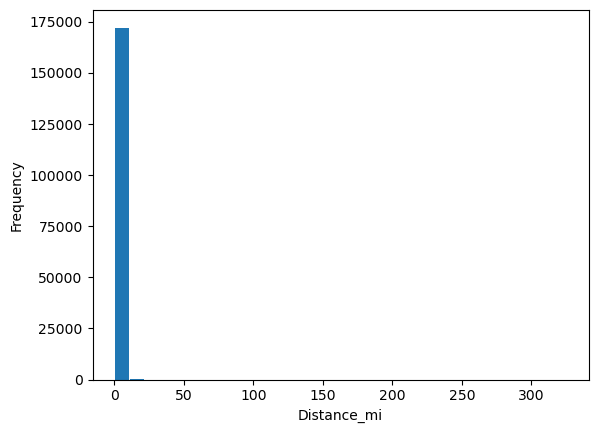

>>> plotting distribution for Temperature_F


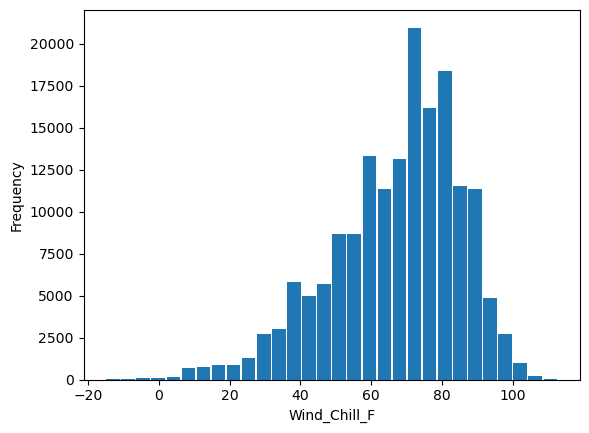

>>> plotting distribution for Humidity_perc


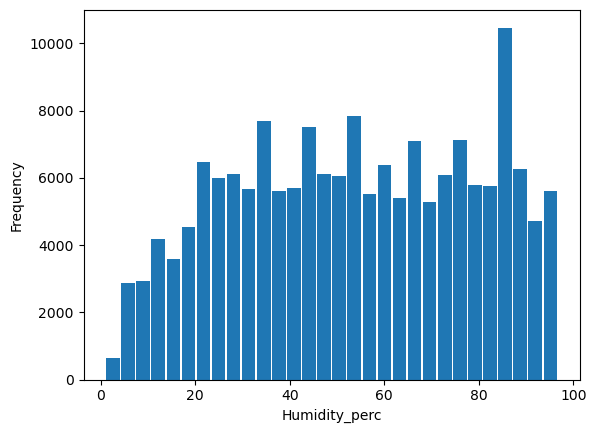

>>> plotting distribution for Pressure_in


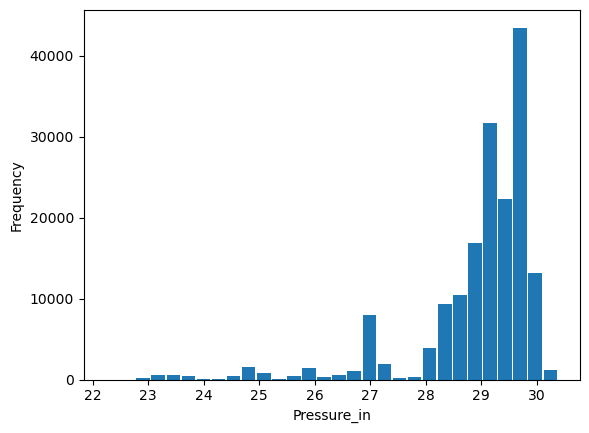

>>> plotting distribution for Visibility_mi


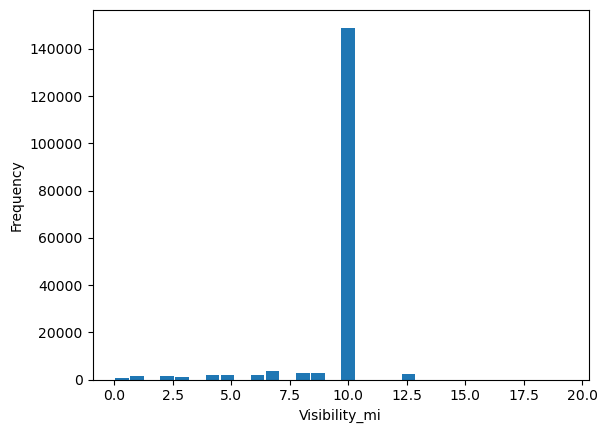

>>> plotting distribution for Wind_Speed_mph


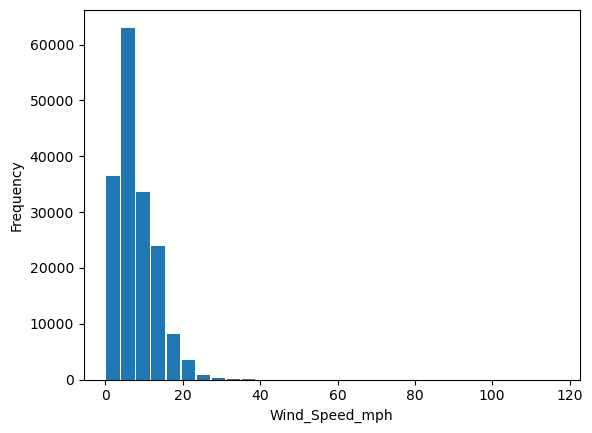

>>> plotting distribution for Precipitation_in


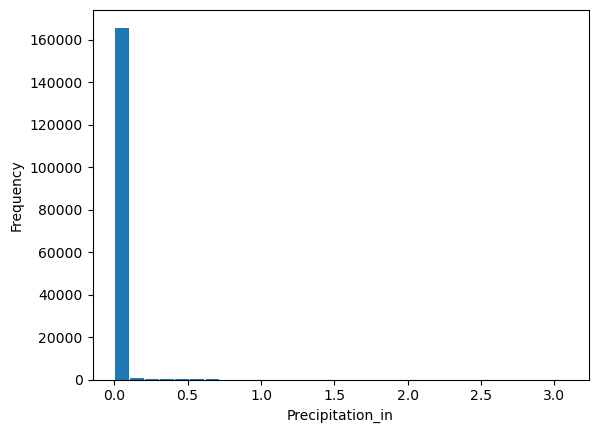

In [27]:
# Analisi distribuzione variabili continue
continuos_features=['Distance_mi', 'Temperature_F', 'Wind_Chill_F', 'Humidity_perc', 'Pressure_in', 'Visibility_mi', 'Wind_Speed_mph', 'Precipitation_in']
df.createOrReplaceTempView("Incidents_Data")

# Itera attraverso le colonne e crea gli istogrammi
for col in continuos_features:
    print(f">>> plotting distribution for {col}")
    query = spark.sql(f'SELECT {col} FROM Incidents_Data') 
    h = query.select(col).rdd.flatMap(lambda x: x).histogram(30) # seleziono colonna specificata dalla query poi converto tutto in un RDD e applico la funzione flatMap per "appiattire" i valori in un singolo elenco. Infine creo istogramma diviso in 50 bin e restituisco una tupla contenente i bin e le frequenze.
    
    # traspone la tupla ottenuta dall'istogramma per ottenere una lista di tuple, ognuna rappresentante un bin e la sua frequenza.
    dfh = pd.DataFrame(
        list(zip(*h)), 
        columns=['bin', 'frequency']
    )
    # estraggo dai dal dataframe pandas per ottenere i bin e le frequenze necessari per il plotting
    bins = dfh['bin']
    counts = dfh['frequency']
    #  classic pandas syntax
    plt.hist(bins, len(bins), weights=counts, rwidth=0.9)
    plt.xlabel(f'{col}', size=10)
    plt.ylabel("Frequency", size=10)
    #plt.grid(True) 
    plt.show()


Categoric/discrete variables frequency

In [14]:
discrete_features=['Severity','State', 'Wind_Direction', 'Weather_Condition', 'Astronomical_Twilight','season','month','day_of_the_week','hour']

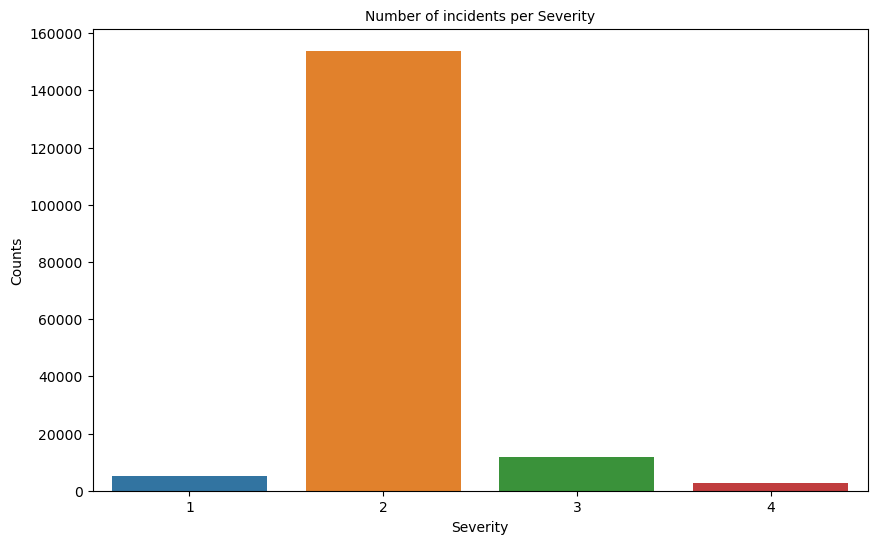

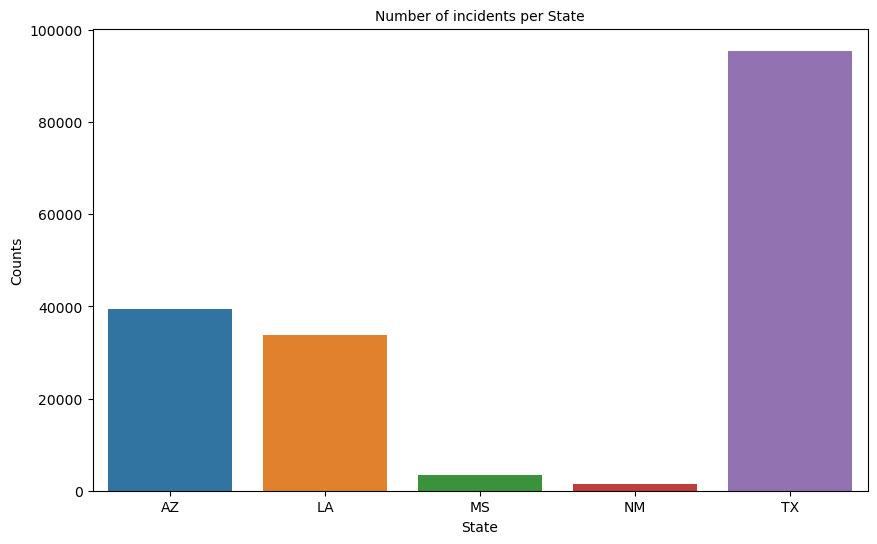

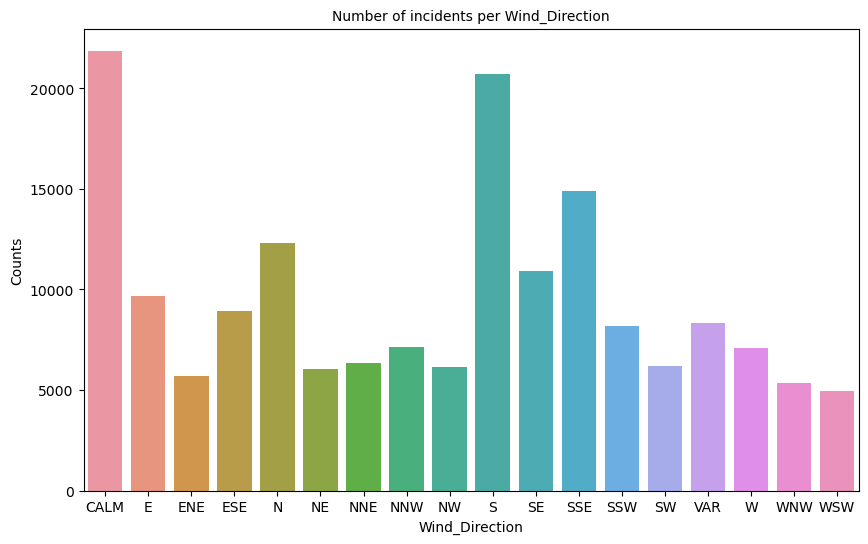

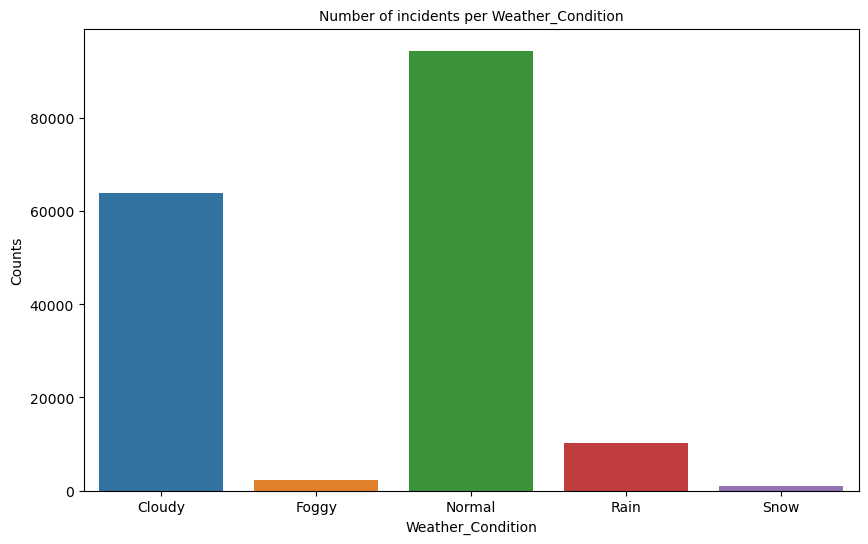

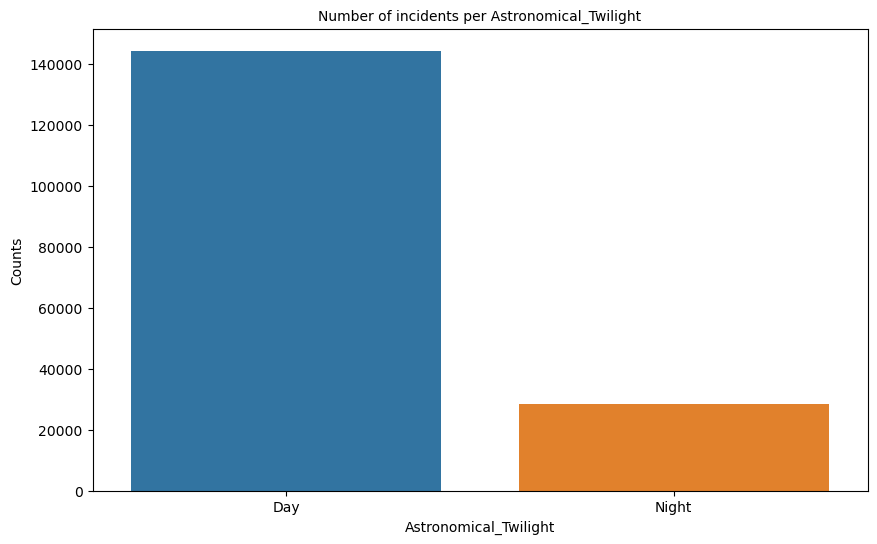

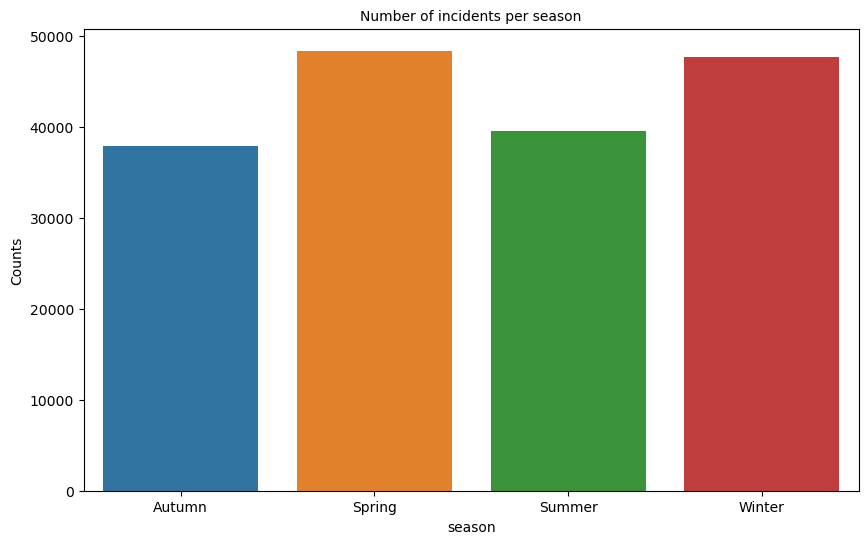

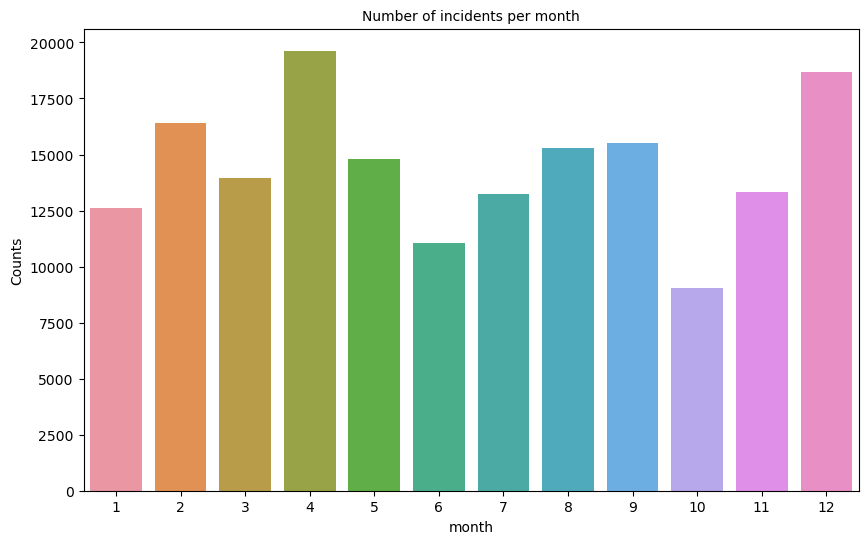

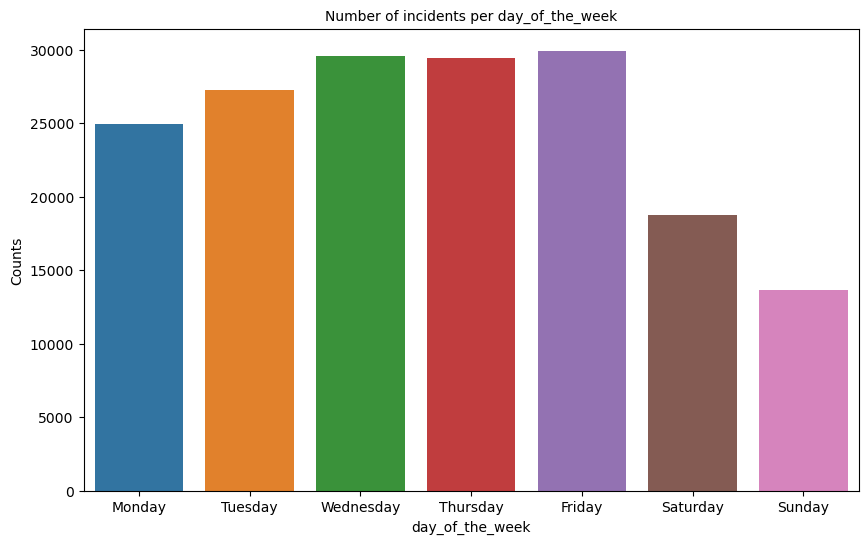

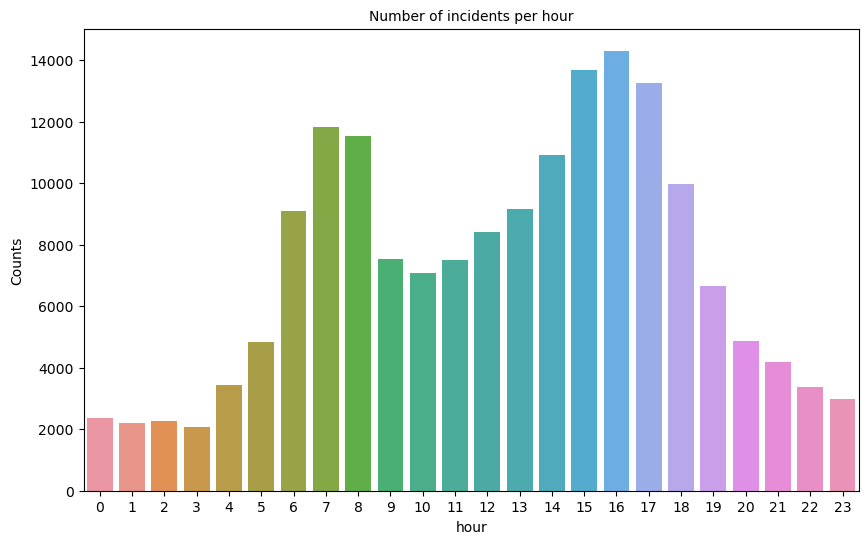

In [23]:
# Analisi barplot variabili categoriche/discrete
discrete_features=['Severity','State', 'Wind_Direction', 'Weather_Condition', 'Astronomical_Twilight','season','month','day_of_the_week','hour']
df.createOrReplaceTempView("Incidents_Data")

for feature in discrete_features:
    feature_freq = spark.sql(f"SELECT {feature}, COUNT(*) as count FROM Incidents_Data GROUP BY {feature}").toPandas()
    feature_freq = feature_freq.sort_values(by=feature)
    plt.figure(figsize=(10, 6))
    if feature=='day_of_the_week':
        order_of_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        sns.barplot(x=feature, y="count", data=feature_freq, order=order_of_days)
        plt.xlabel(feature, size=10)
        plt.ylabel("Counts", size=10)
        plt.title(f"Number of incidents per {feature}", size=10)
        plt.show()
    else:
        sns.barplot(x=feature, y="count", data=feature_freq)
        plt.xlabel(feature, size=10)
        plt.ylabel("Counts", size=10)
        plt.title(f"Number of incidents per {feature}", size=10)
        plt.show()

Boolean variables frequency

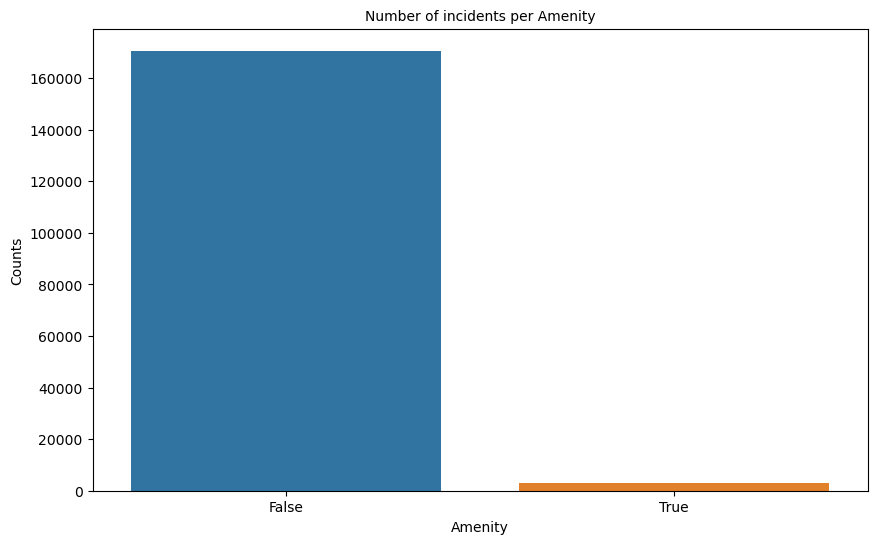

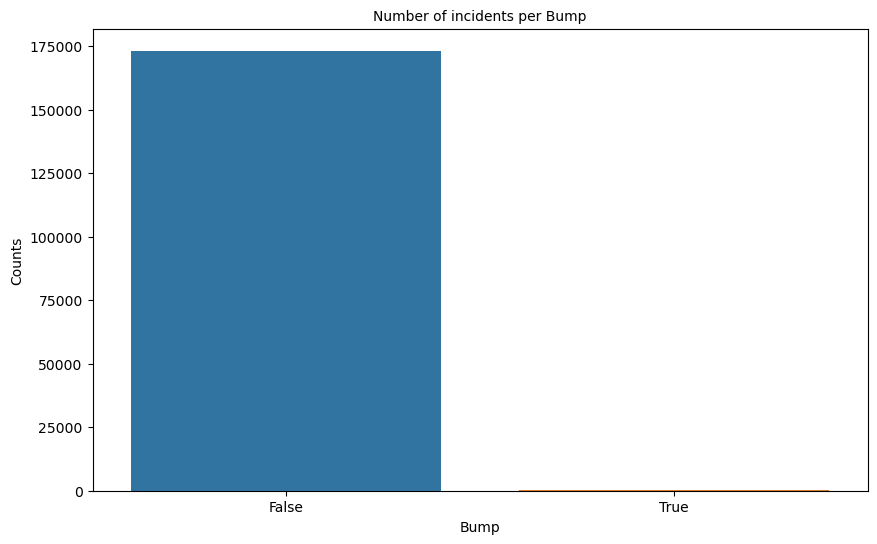

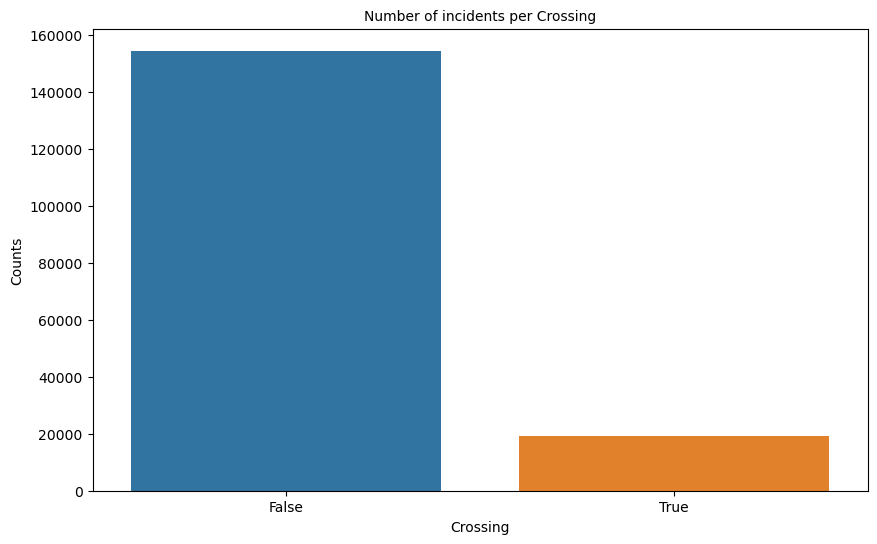

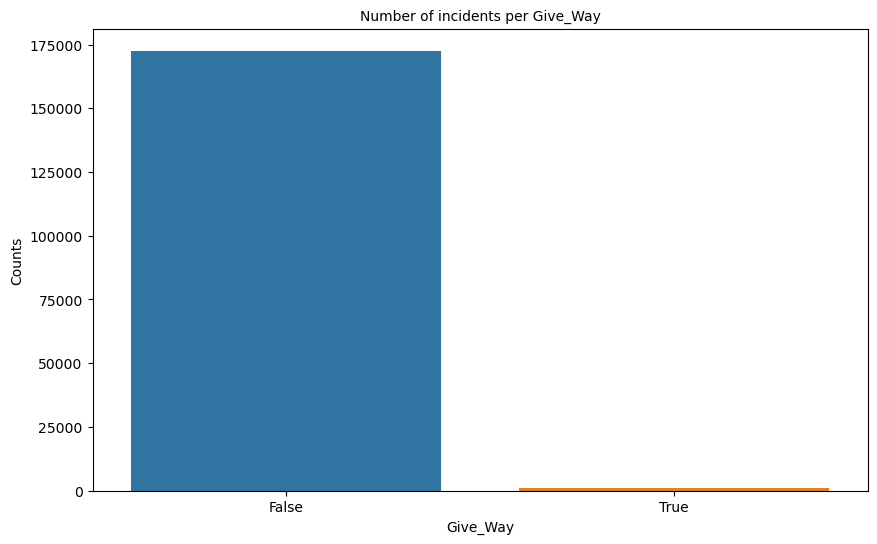

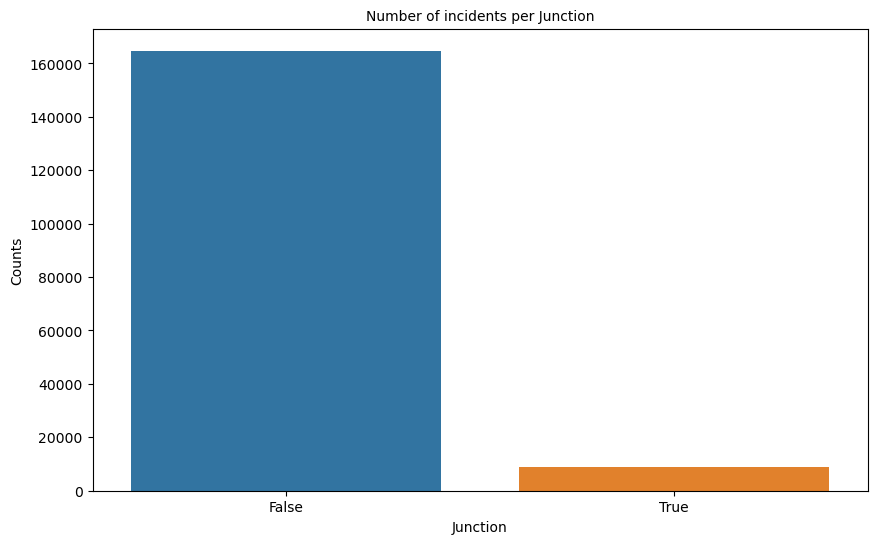

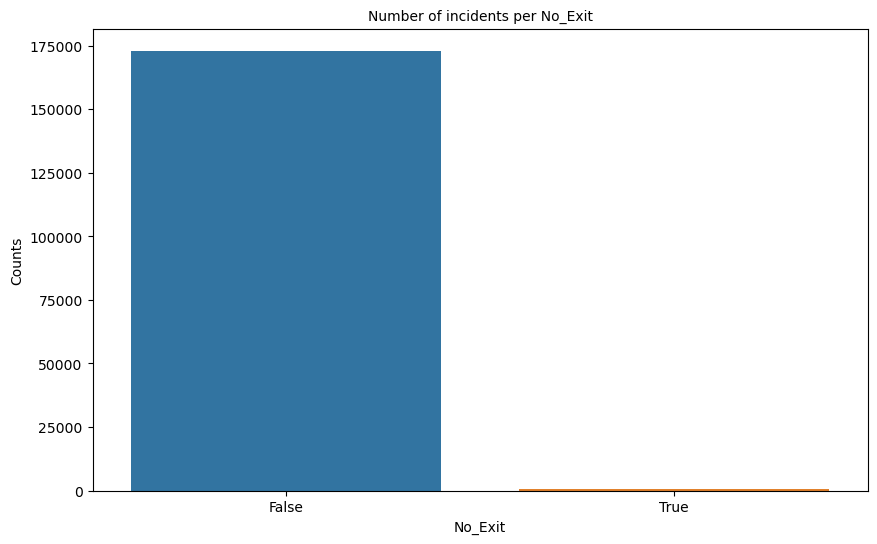

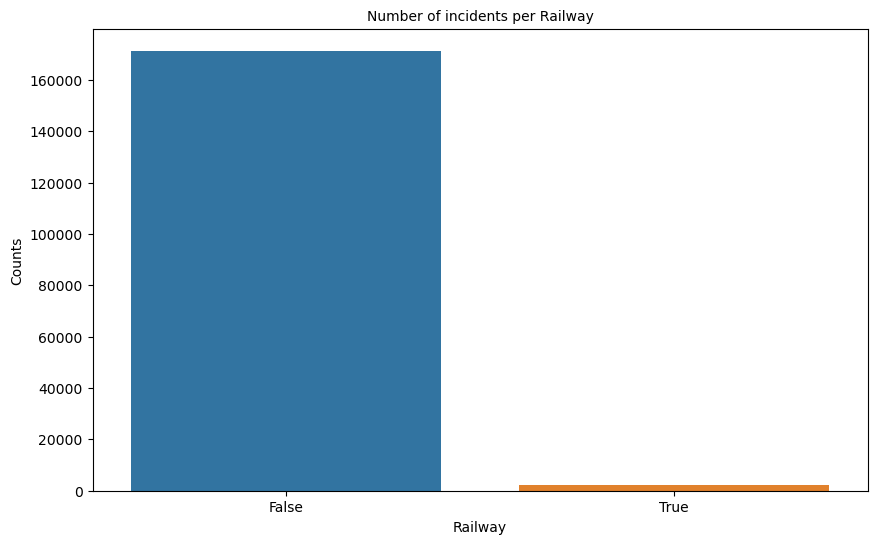

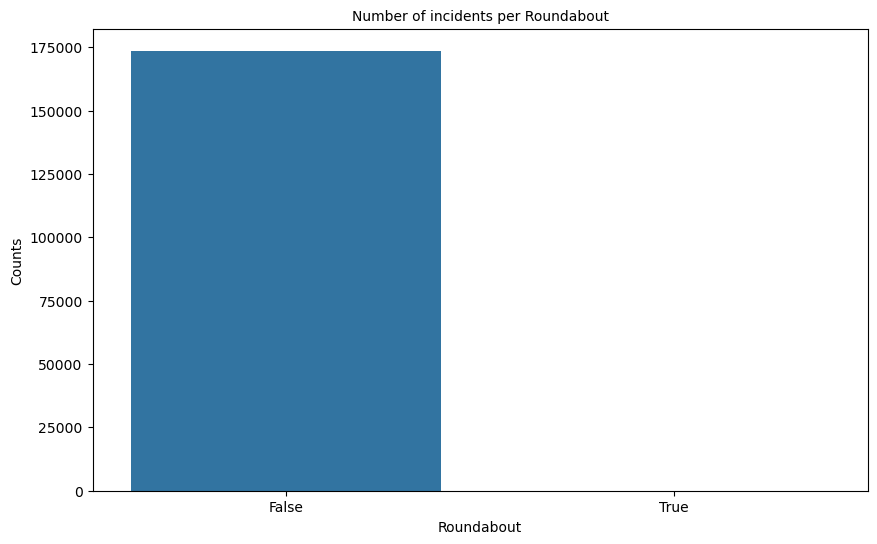

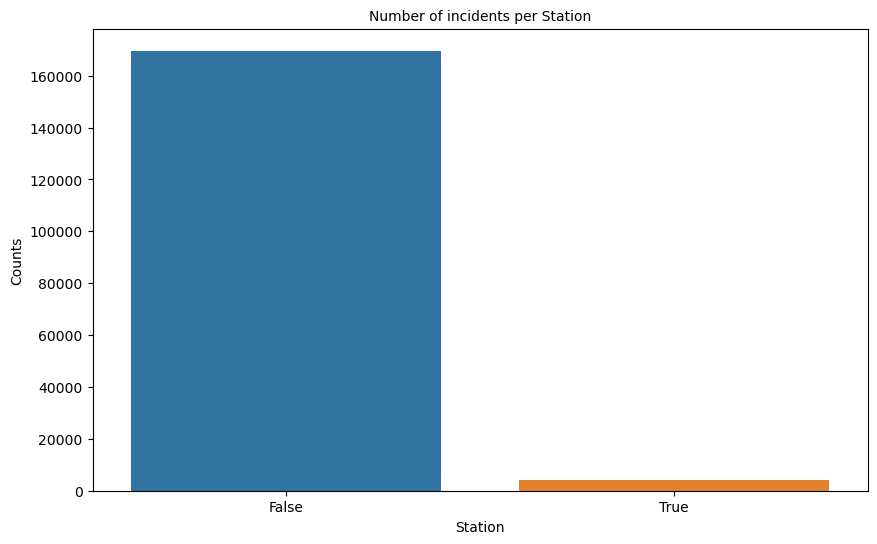

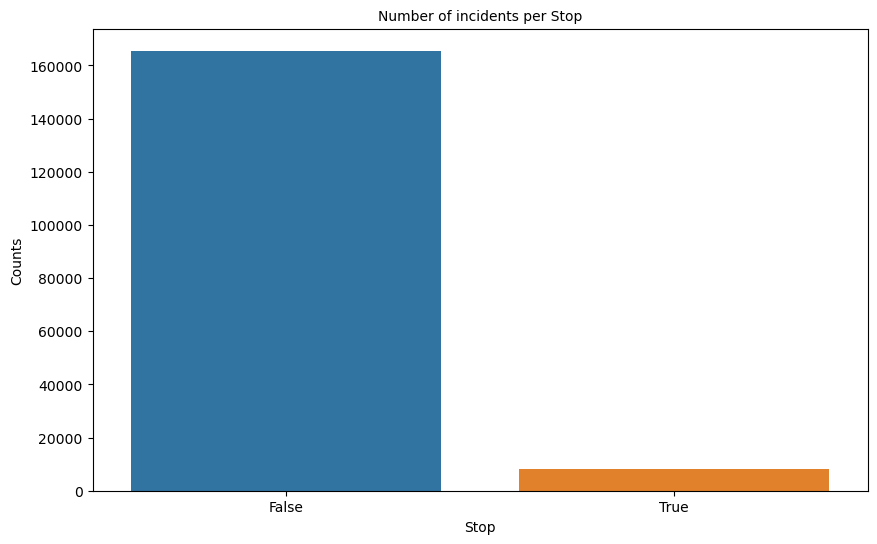

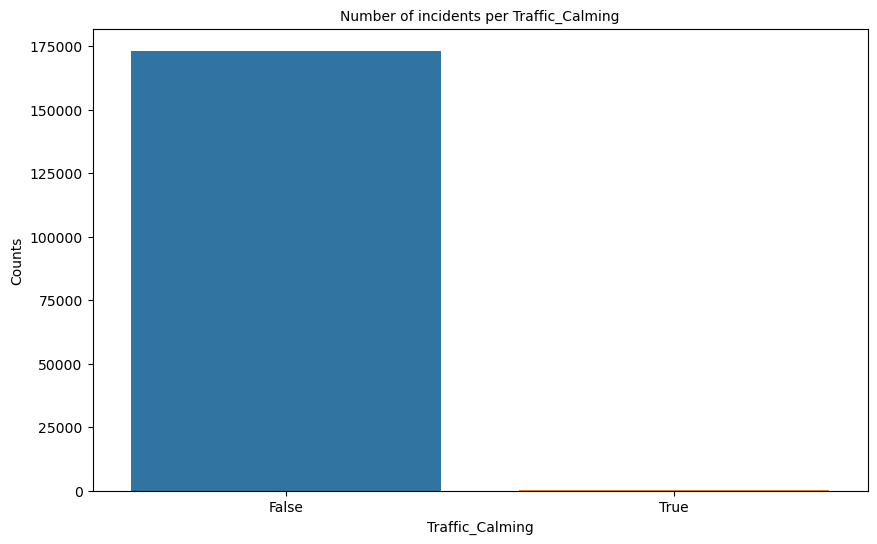

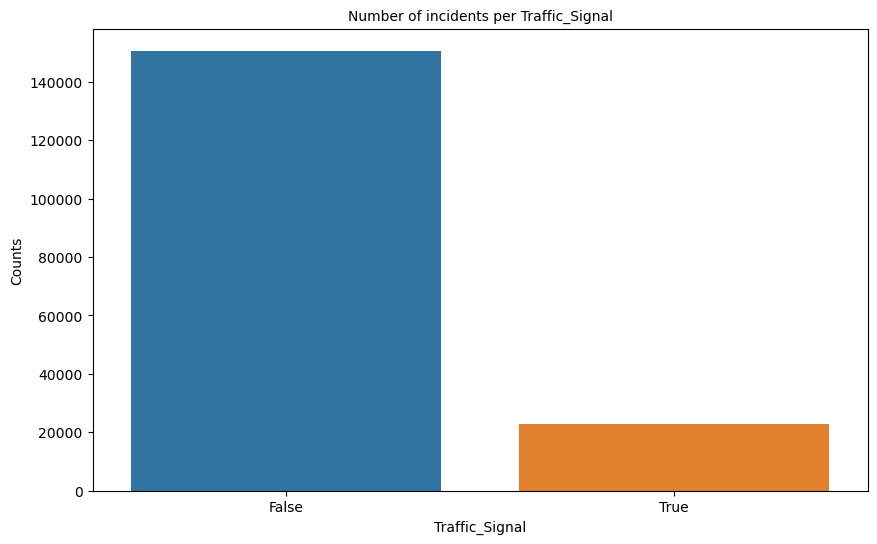

In [59]:
boolean_features=['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal']
df.createOrReplaceTempView("Incidents_Data")

for feature in boolean_features:
    feature_freq = spark.sql(f"SELECT {feature}, COUNT(*) as count FROM Incidents_Data GROUP BY {feature}").toPandas()
    feature_freq = feature_freq.sort_values(by=feature)
    plt.figure(figsize=(10, 6))
    if feature=='day_of_the_week':
        order_of_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        sns.barplot(x=feature, y="count", data=feature_freq, order=order_of_days)
        plt.xlabel(feature, size=10)
        plt.ylabel("Counts", size=10)
        plt.title(f"Number of incidents per {feature}", size=10)
        plt.show()
    else:
        sns.barplot(x=feature, y="count", data=feature_freq)
        plt.xlabel(feature, size=10)
        plt.ylabel("Counts", size=10)
        plt.title(f"Number of incidents per {feature}", size=10)
        plt.show()

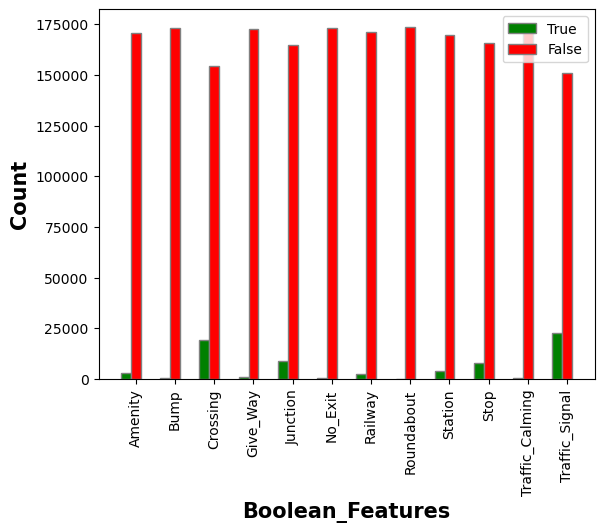

In [57]:
# Analisi barplot variabili booleane
boolean_features=['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal']
lista_true=[]
lista_false=[]
for feature in boolean_features:
    feature_freq = spark.sql(f"SELECT {feature}, COUNT(*) as count FROM Incidents_Data GROUP BY {feature}").toPandas()
    feature_freq = feature_freq.sort_values(by=feature)
    #print(feature_freq)
    count=list(feature_freq['count'])
    if len(count)==2:
        lista_true.append(count[1])
        lista_false.append(count[0])
    else:
        if feature_freq[feature]=='False':
            lista_false.append(count[0])
        else:
            lista_true.append(count[0])
barWidth=0.25
br1 = np.arange(len(lista_true)) 
br2 = [x + barWidth for x in br1] 
plt.bar(br1, lista_true, color ='g', width = barWidth, 
        edgecolor ='grey', label ='True') 
plt.bar(br2, lista_false, color ='r', width = barWidth, 
        edgecolor ='grey', label ='False') 
plt.xlabel('Boolean_Features', fontweight ='bold', fontsize = 15) 
plt.ylabel('Count', fontweight ='bold', fontsize = 15) 
plt.xticks([r+barWidth  for r in range(len(lista_true))], 
        boolean_features, rotation='vertical')
 
plt.legend()
plt.show() 


In [32]:
# Per le variabili booleane mi creo anche un dataframe di conteggi per visualizzare meglio i valori binari
df.createOrReplaceTempView("Incidents_Data")
boolean_features = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal']

results = []

for feature in boolean_features:
    counts = df.groupBy(feature).count().collect()

    for count in counts:
        results.append({'Feature': feature, 'Value': count[feature], 'Count': count['count']})

result_df = spark.createDataFrame(results)
result_df.show(result_df.count(), truncate=False)


+------+---------------+-----+
|Count |Feature        |Value|
+------+---------------+-----+
|2963  |Amenity        |true |
|169587|Amenity        |false|
|312   |Bump           |true |
|172238|Bump           |false|
|19003 |Crossing       |true |
|153547|Crossing       |false|
|972   |Give_Way       |true |
|171578|Give_Way       |false|
|8764  |Junction       |true |
|163786|Junction       |false|
|576   |No_Exit        |true |
|171974|No_Exit        |false|
|2248  |Railway        |true |
|170302|Railway        |false|
|172547|Roundabout     |false|
|3     |Roundabout     |true |
|3959  |Station        |true |
|168591|Station        |false|
|7996  |Stop           |true |
|164554|Stop           |false|
|374   |Traffic_Calming|true |
|172176|Traffic_Calming|false|
|22788 |Traffic_Signal |true |
|149762|Traffic_Signal |false|
+------+---------------+-----+



ANALISI AGGIUNTIVE: 


1)STATES VS SEVERITY
2)SEASON VS SEVERITY
3)MONTH VS SEVERITY
4)DAY_OF_THE_WEEK VS SEVERITY
5)HOUR VS SEVERITY

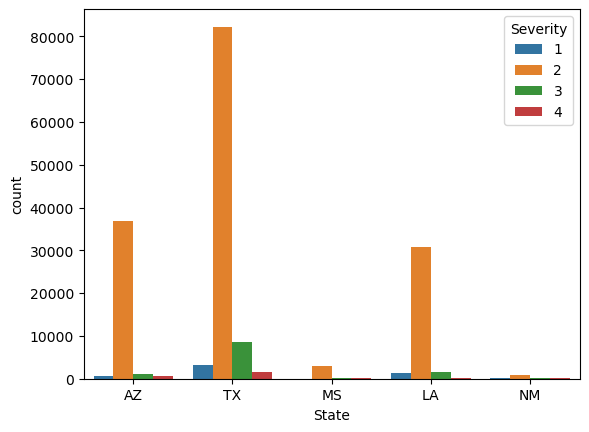

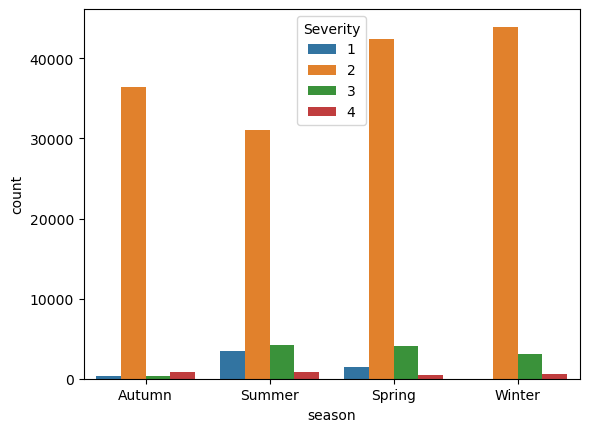

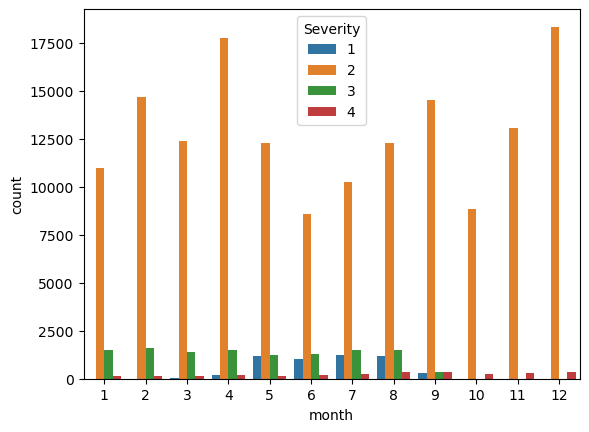

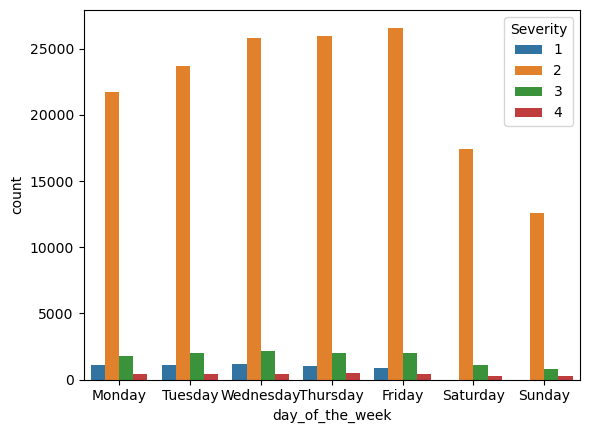

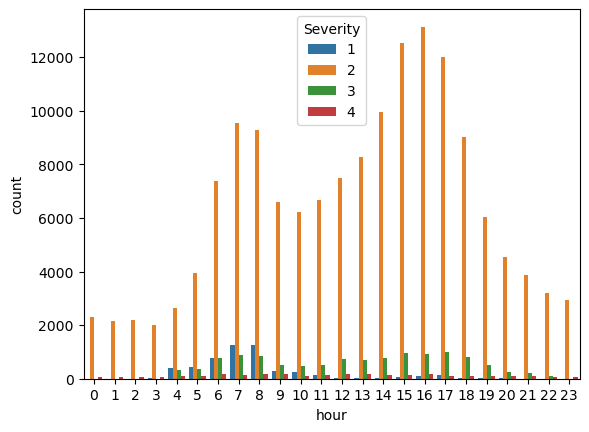

In [20]:
lista=['State','season','month','day_of_the_week','hour']
for col in lista:
    count_ = df.groupBy(col,'Severity').count().toPandas()
    if col=='day_of_the_week':
        order_of_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        sns.barplot(x=col, y="count", data=count_, hue='Severity', order=order_of_days)
        plt.show()
    else:
        sns.barplot(x=col, y="count", data=count_, hue='Severity')
        plt.show()


Scatter variabili continue, per osservare eventuali correlazioni

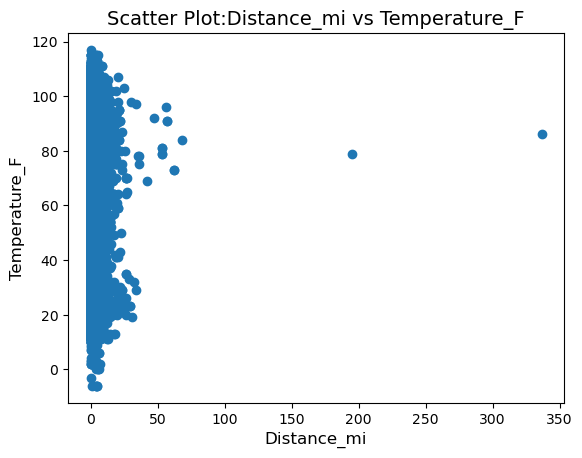

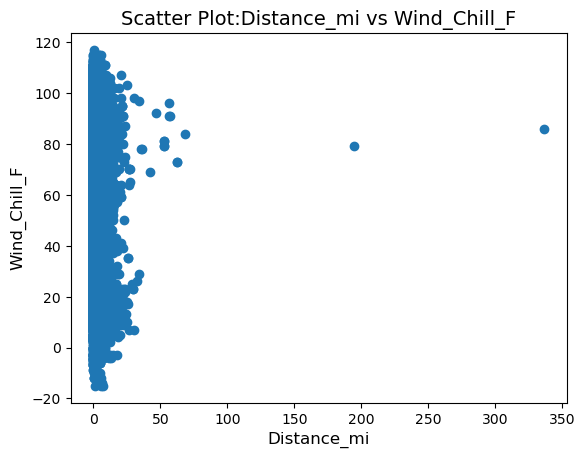

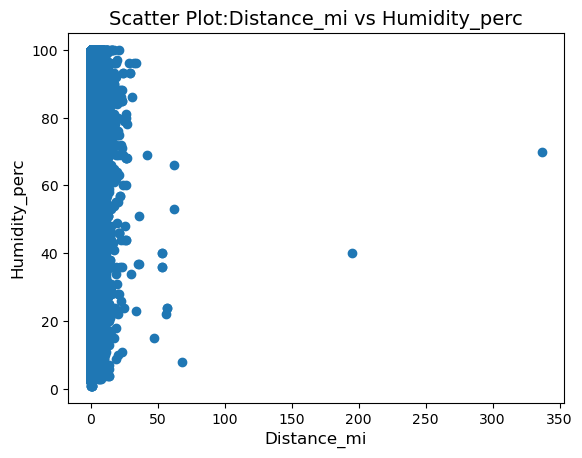

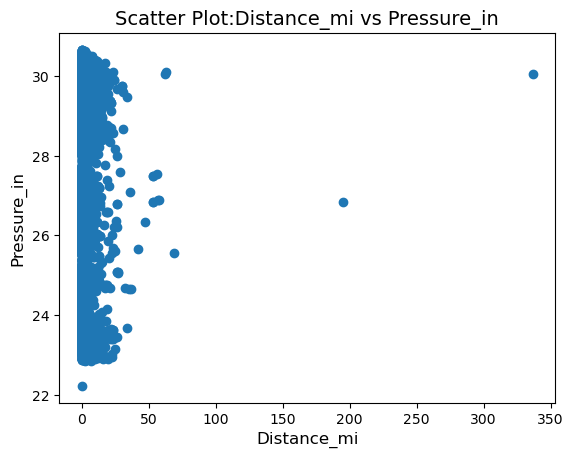

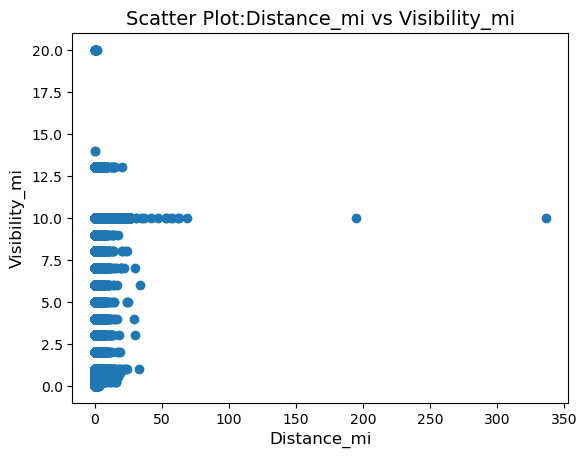

ERROR:root:KeyboardInterrupt while sending command.               (0 + 18) / 18]
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/opt/conda/lib/python3.10/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/opt/conda/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [28]:
i=0
for el1 in continuos_features:
    for el2 in continuos_features[i+1:]:
        filtered_df = df.filter(df[el1].isNotNull() & df[el2].isNotNull())

        data= filtered_df.select(el1, el2).collect()
        x = [row[el1] for row in data]
        y = [row[el2] for row in data]

        # Crea lo scatterplot utilizzando matplotlib
        plt.scatter(x, y)
        plt.xlabel(el1, size=12)
        plt.ylabel(el2, size=12)
        plt.title("Scatter Plot:"+ el1 +" vs "+el2, size=14)
        plt.show()
    i+=1

Scatter per severity

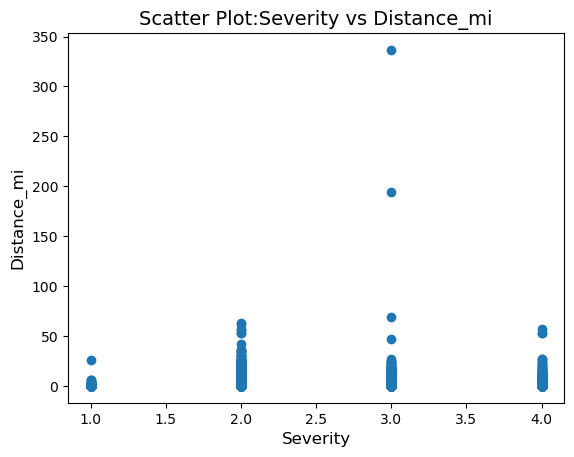

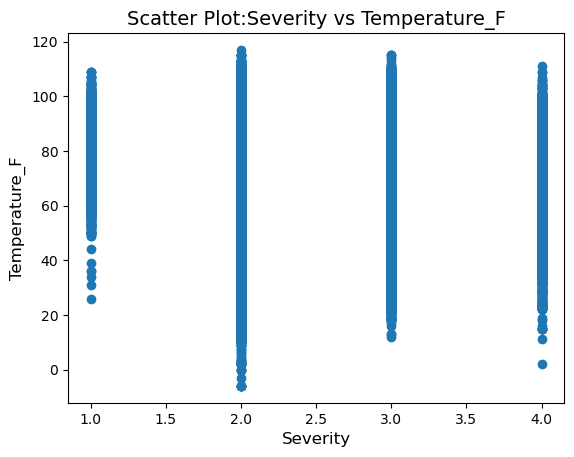

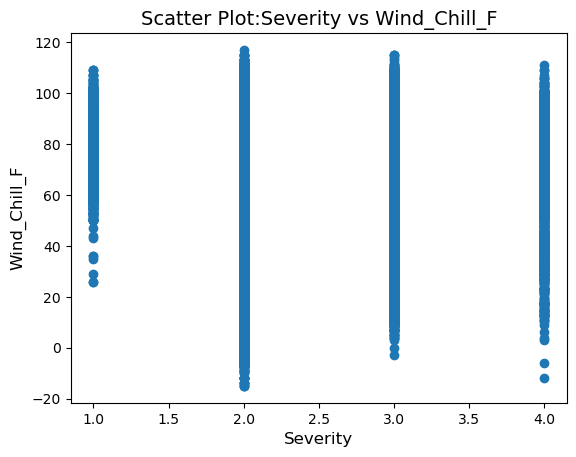

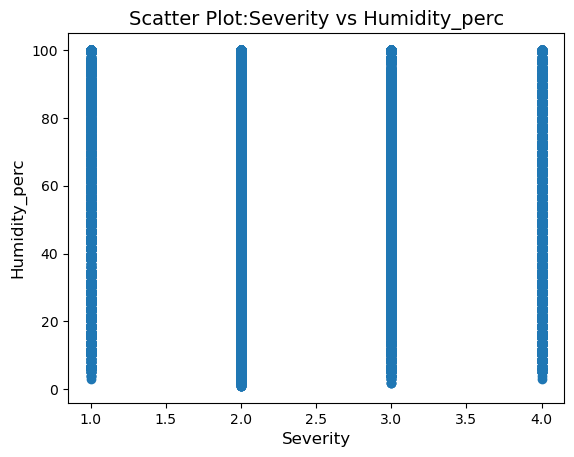

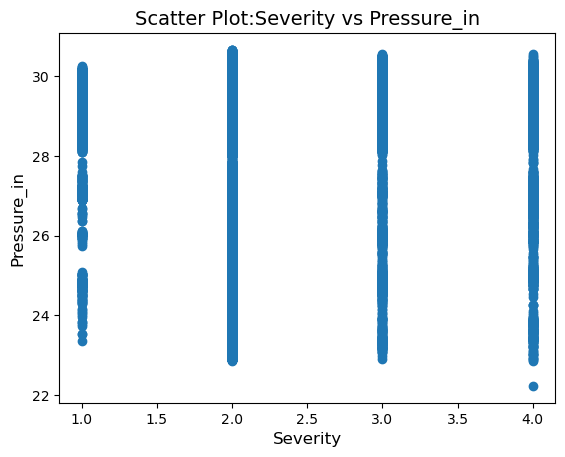

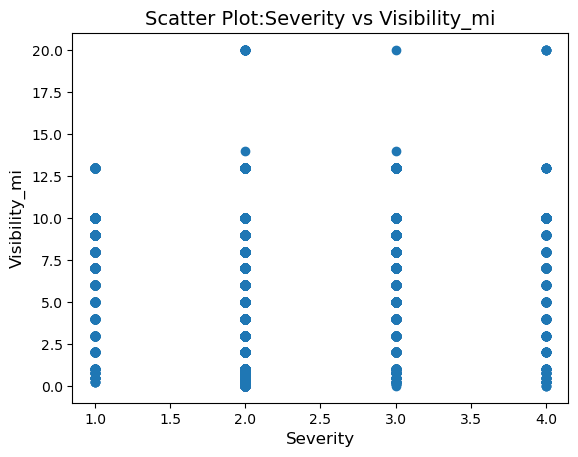

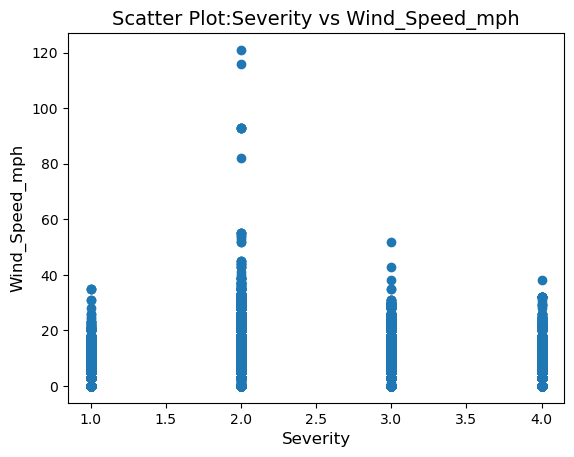

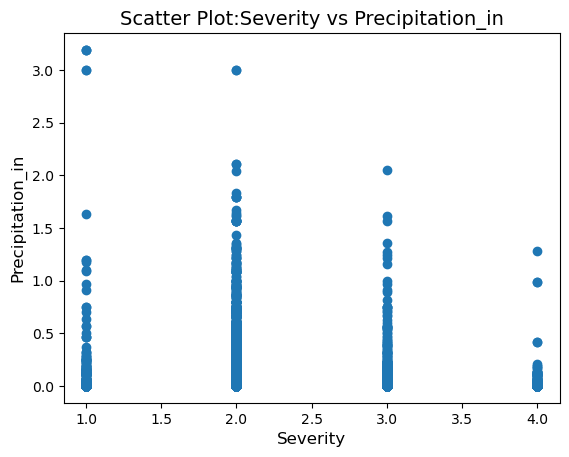

In [36]:
el1='Severity'
for el2 in continuos_features:
    filtered_df = df.filter(df[el1].isNotNull() & df[el2].isNotNull())

    data= filtered_df.select(el1, el2).collect()
    x = [row[el1] for row in data]
    y = [row[el2] for row in data]

    # Crea lo scatterplot utilizzando matplotlib
    plt.scatter(x, y)
    plt.xlabel(el1, size=12)
    plt.ylabel(el2, size=12)
    plt.title("Scatter Plot:"+ el1 +" vs "+el2, size=14)
    plt.show()

Scatter features continue con label severity

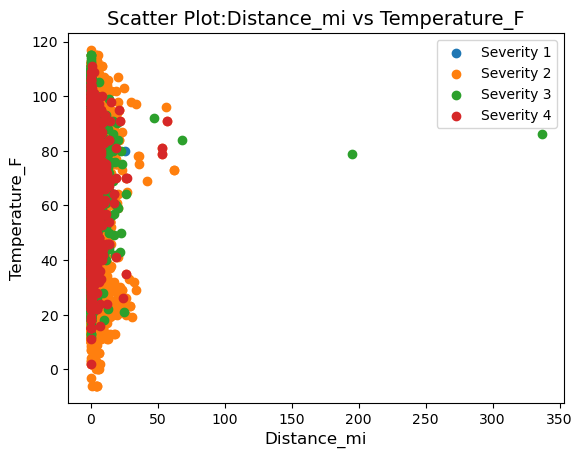

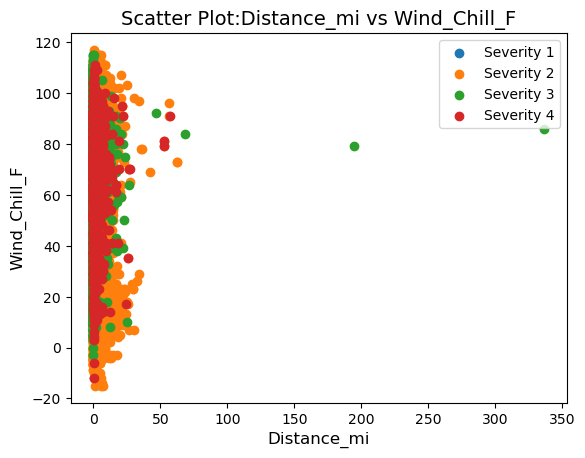

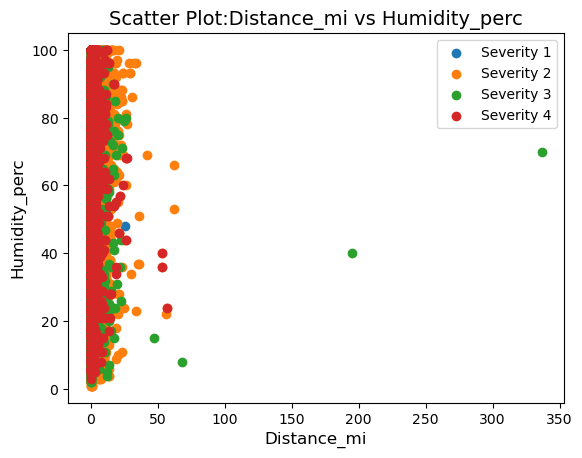

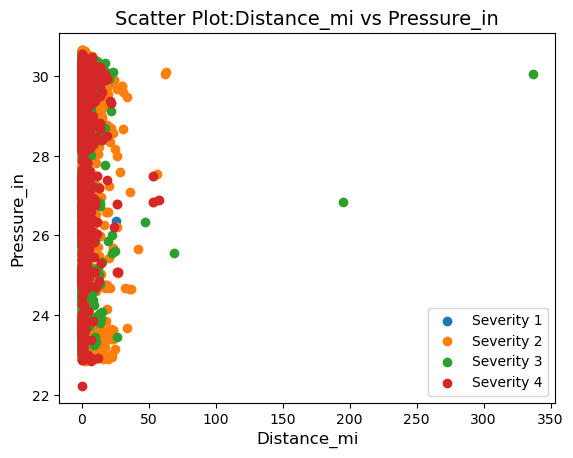

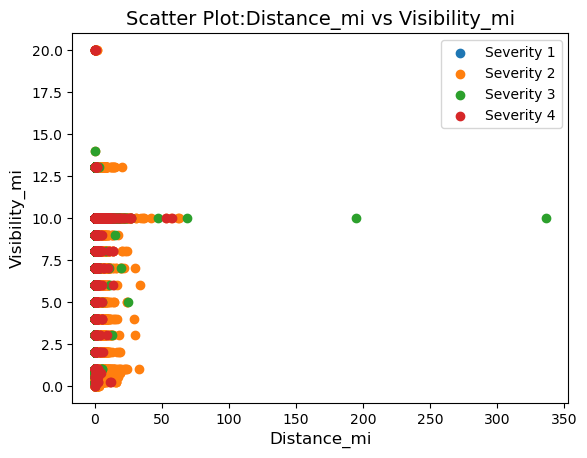

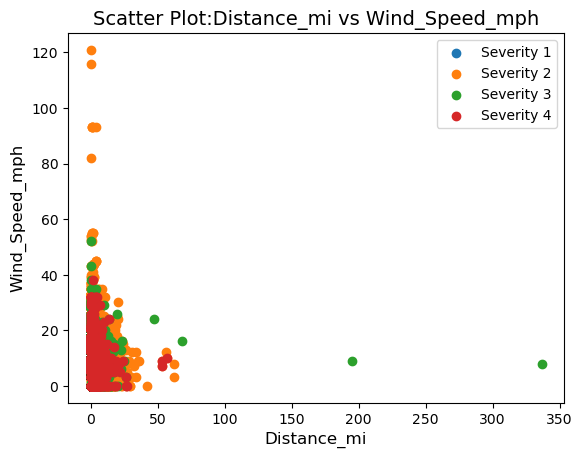

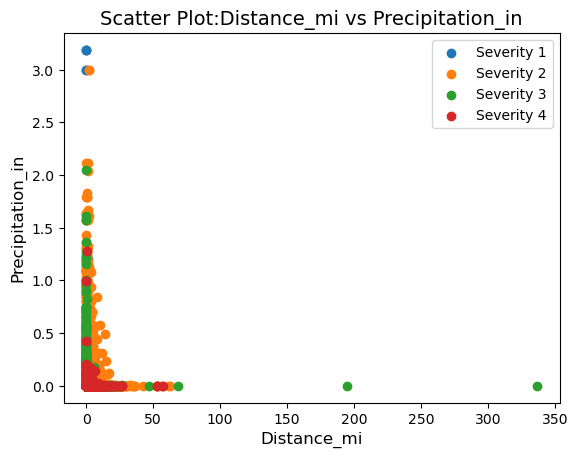

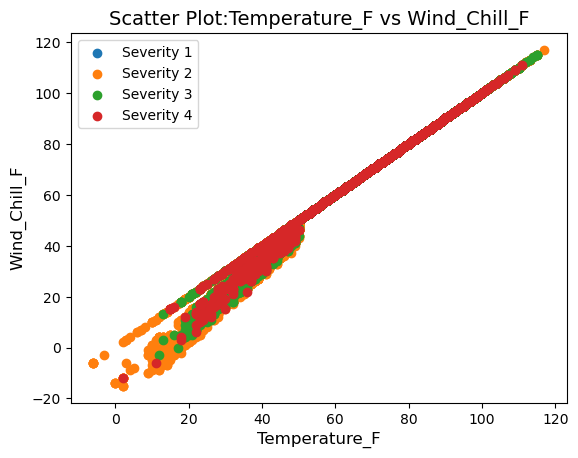

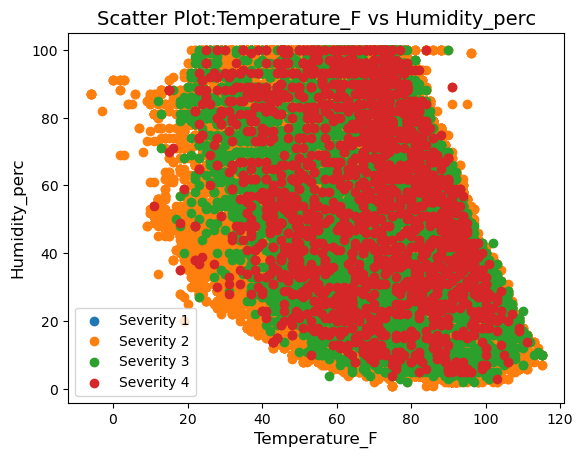

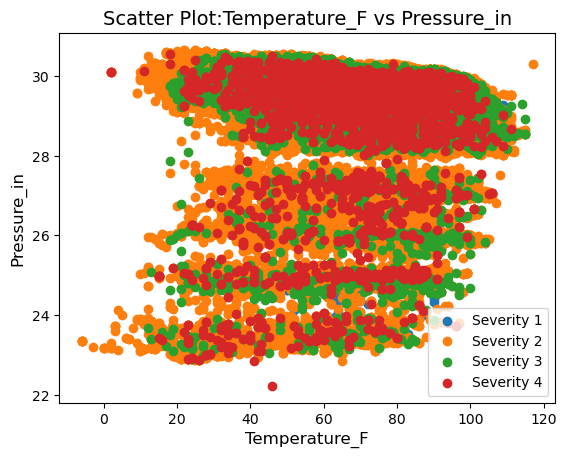

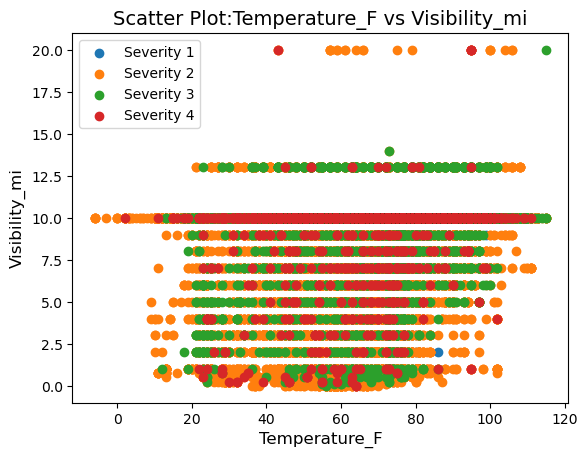

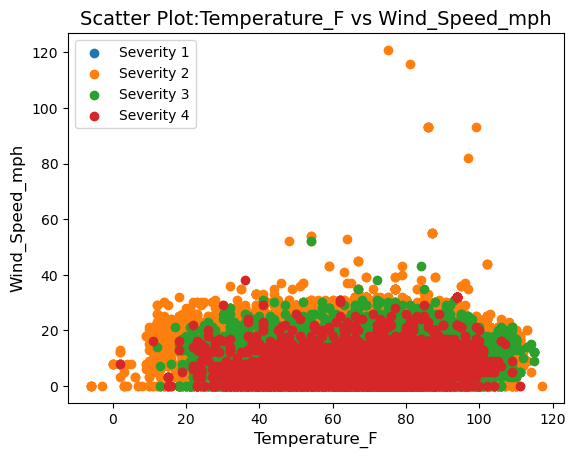

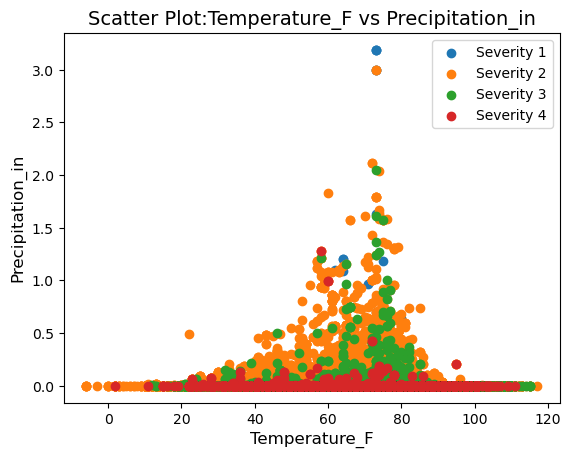

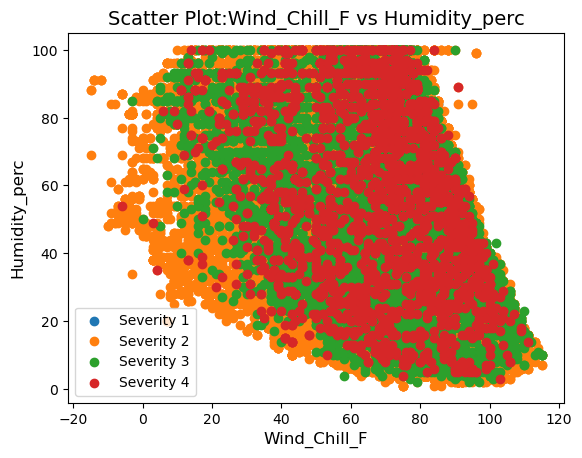

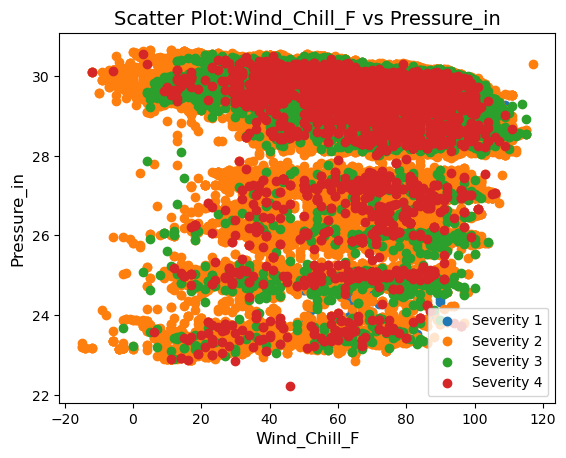

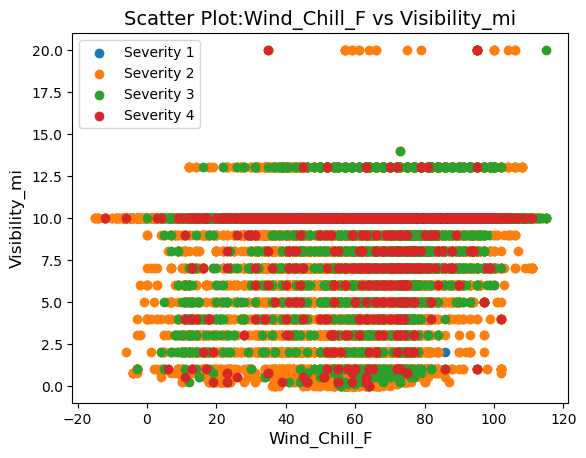

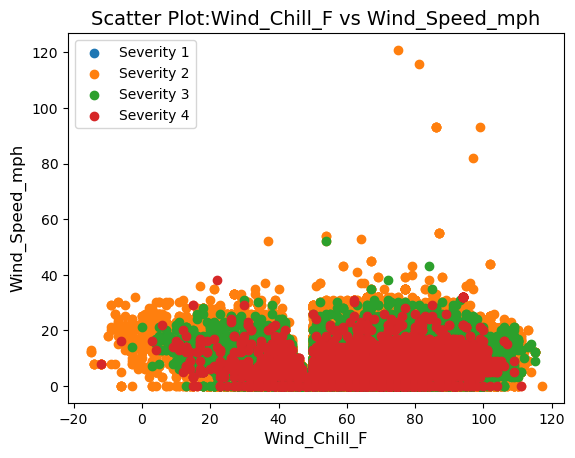

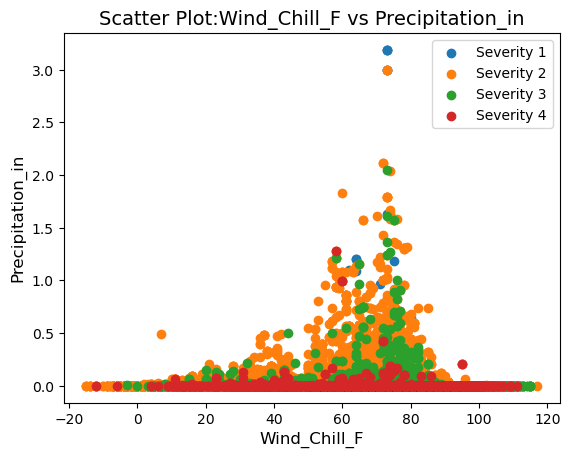

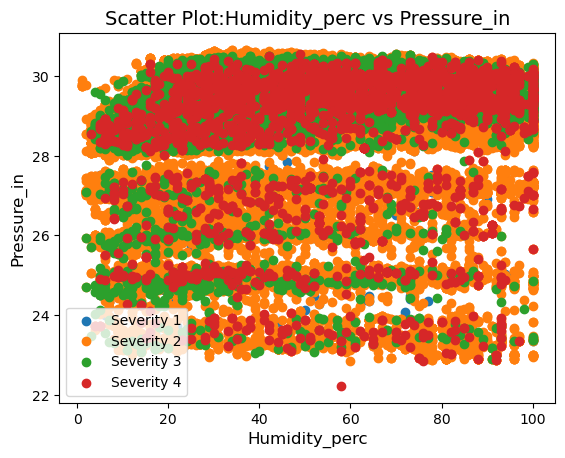

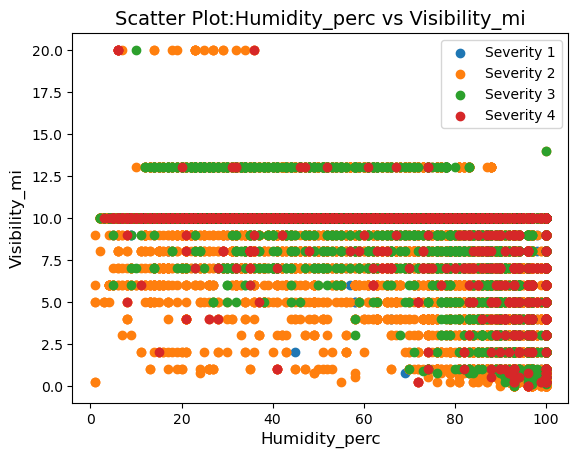

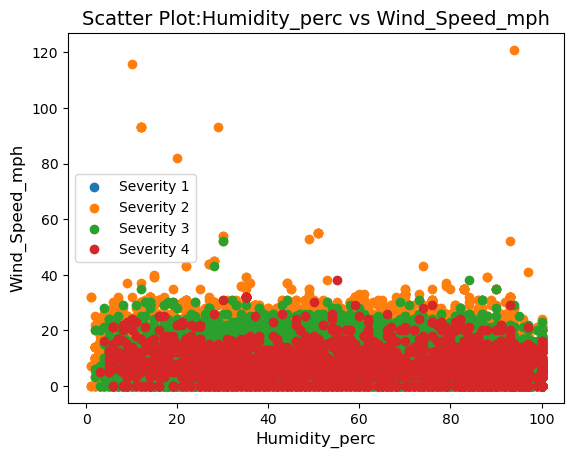

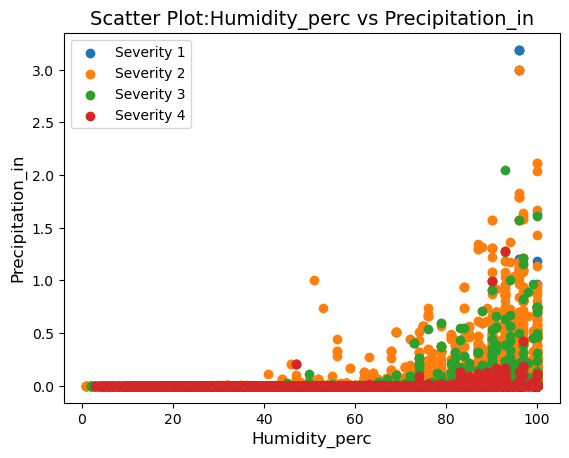

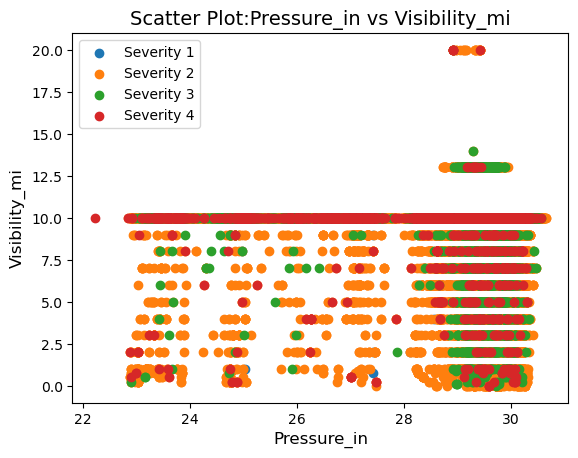

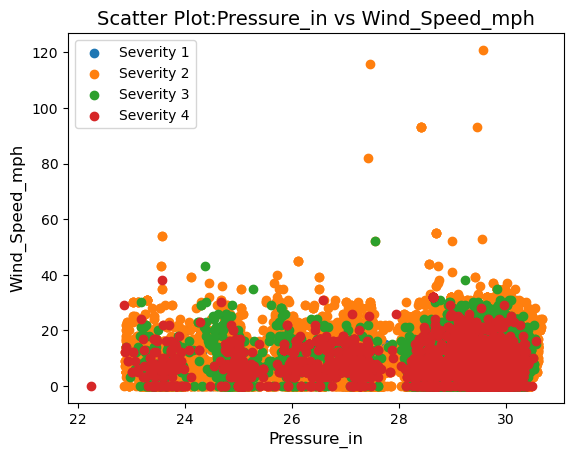

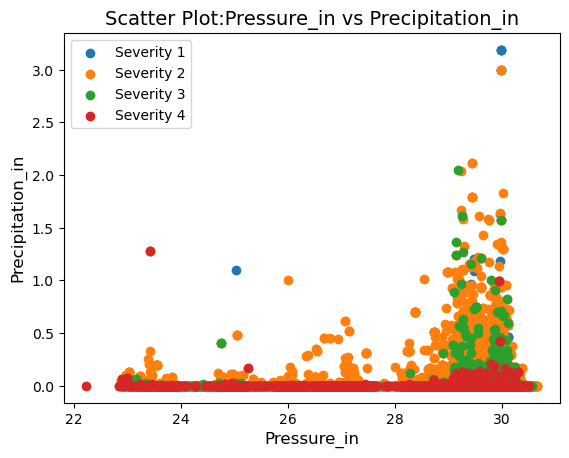

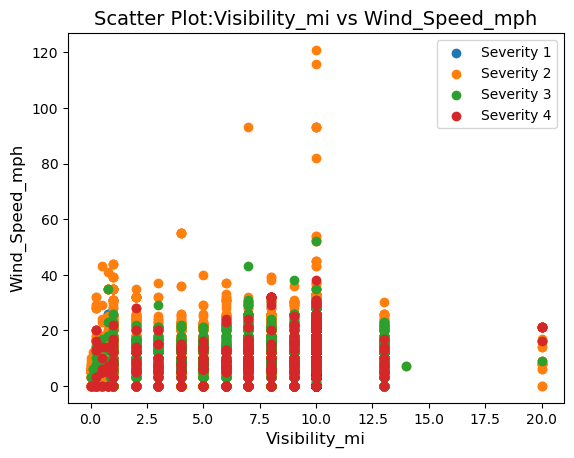

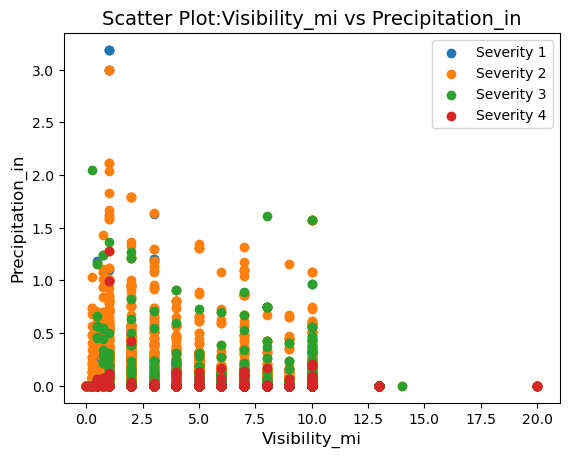

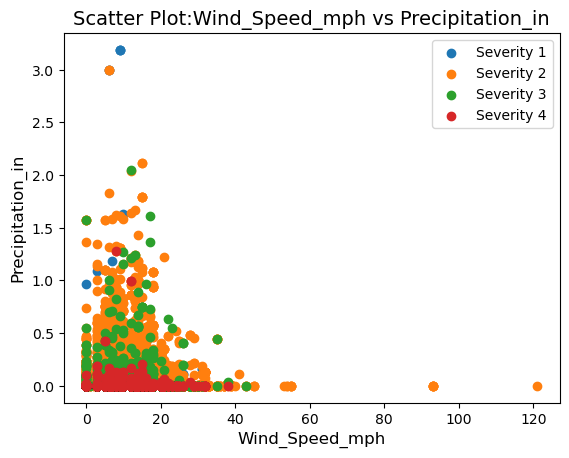

In [38]:
i=0
unique_severity =[1,2,3,4]
for el1 in continuos_features:
    for el2 in continuos_features[i+1:]:
        for severity_val in unique_severity:
            data = df.filter(df['Severity'] == severity_val).select(el1, el2).dropna().collect()
            x = [row[el1] for row in data]
            y = [row[el2] for row in data]

            plt.scatter(x, y, label=f'Severity {severity_val}')

        plt.xlabel(el1, size=12)
        plt.ylabel(el2, size=12)
        plt.title('Scatter Plot:'+el1+ ' vs '+ el2, size=14)
        plt.legend()
        plt.show()
    i+=1


Scatter con label astronomical_twilight

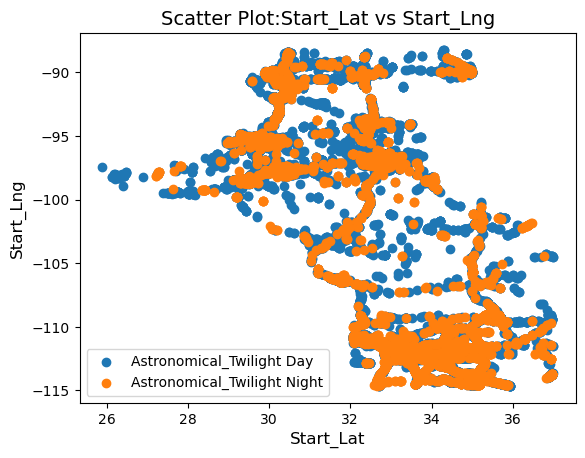

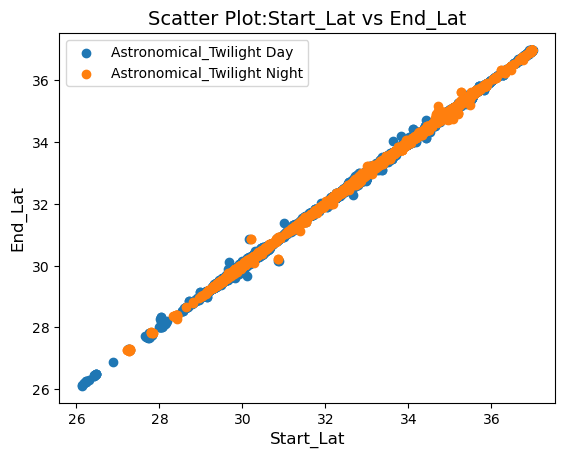

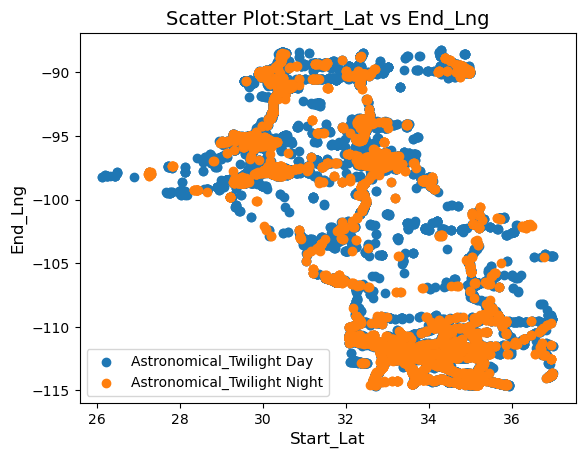

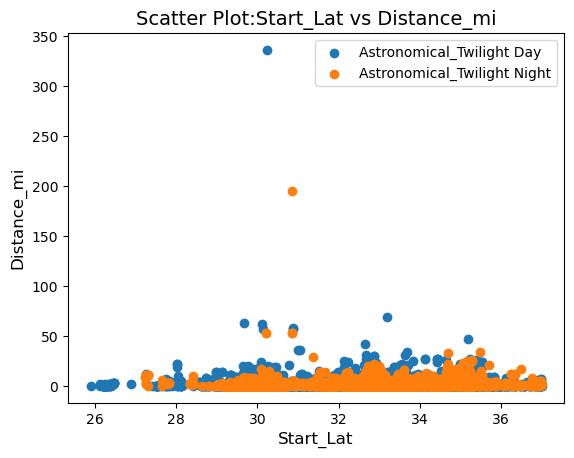

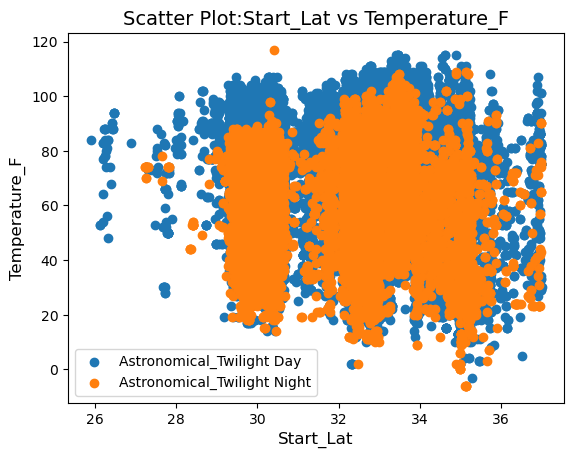

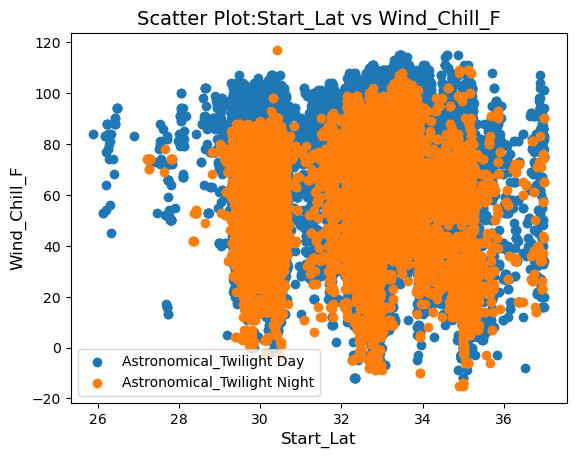

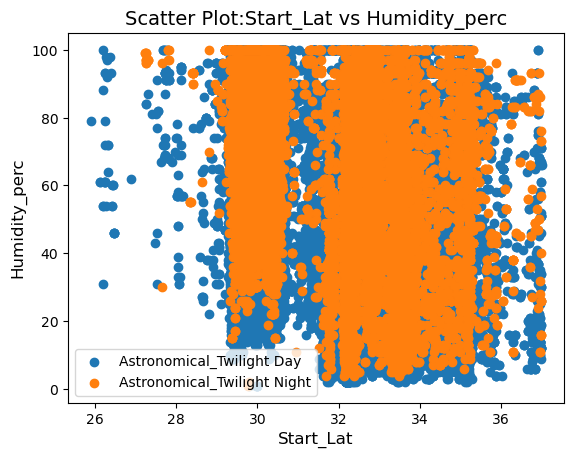

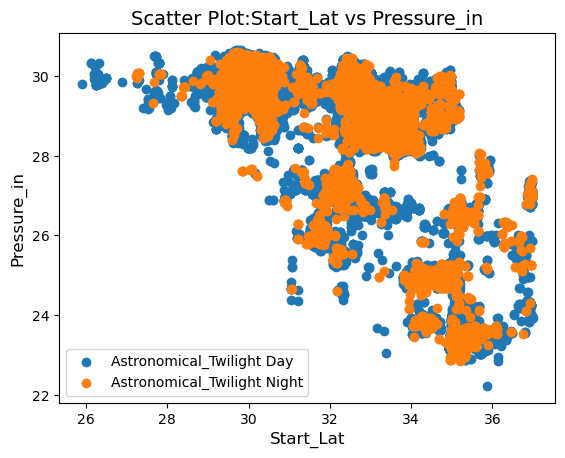

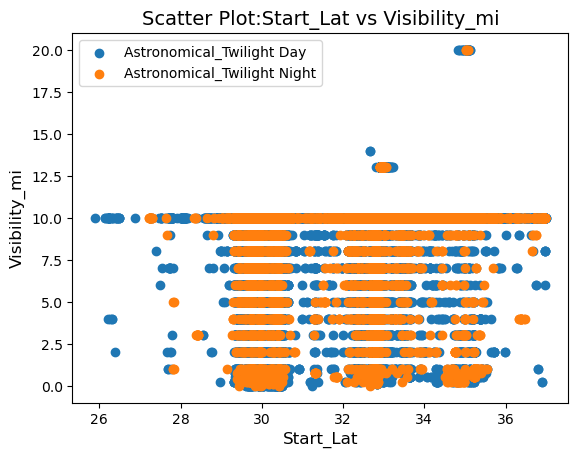

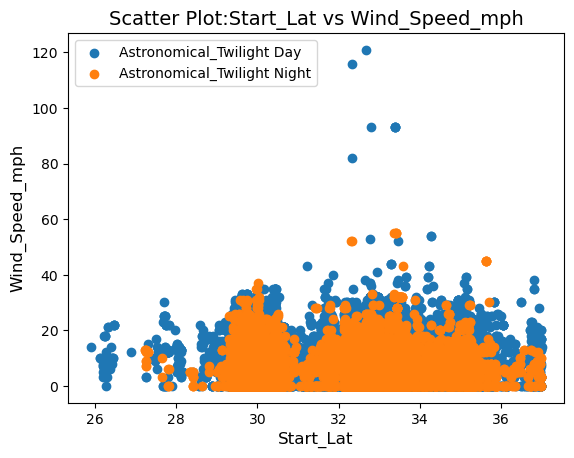

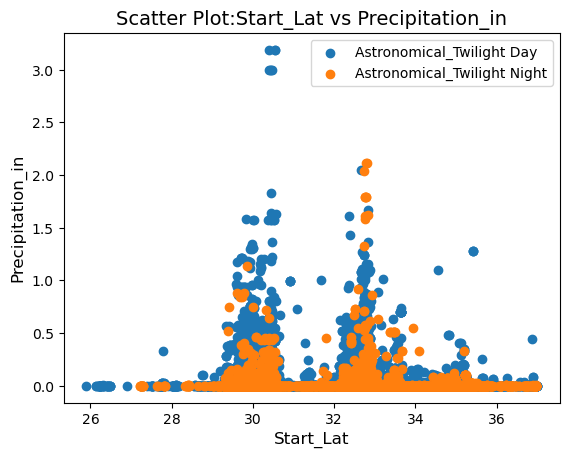

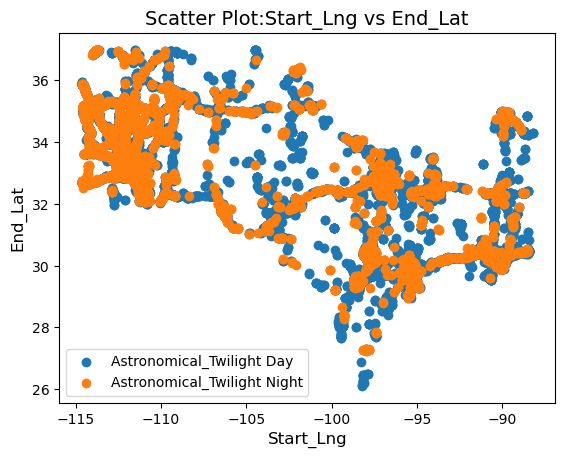

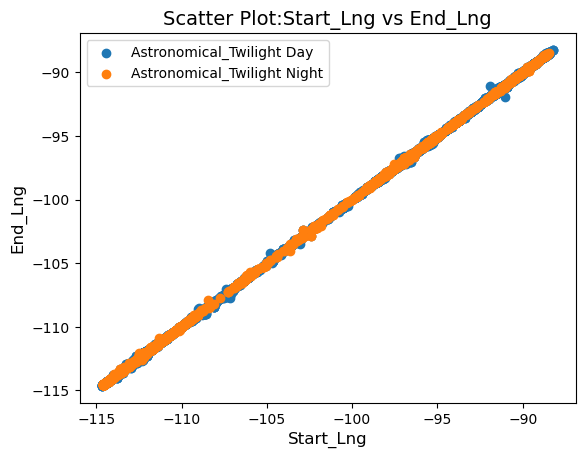

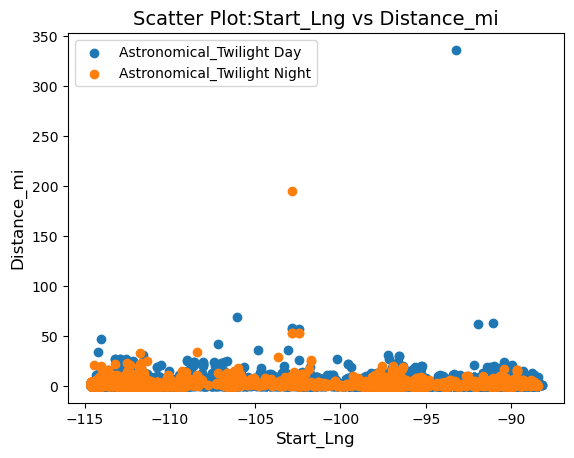

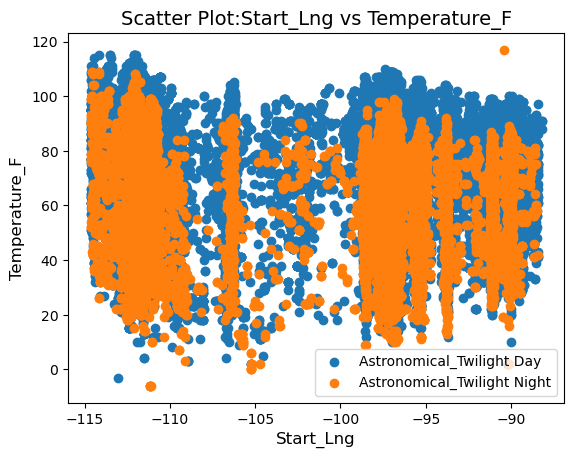

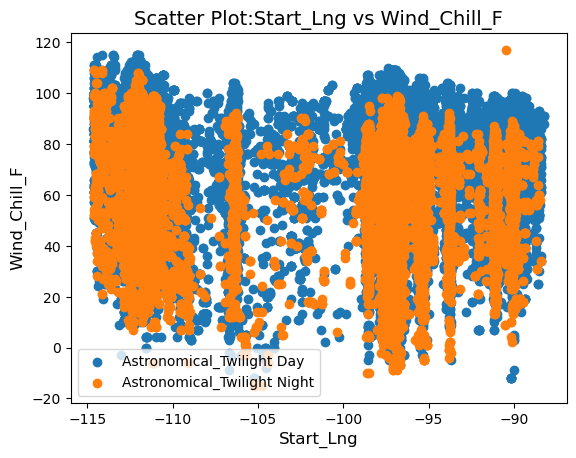

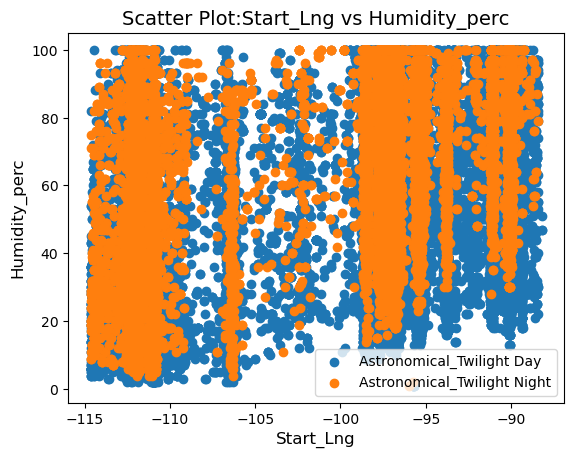

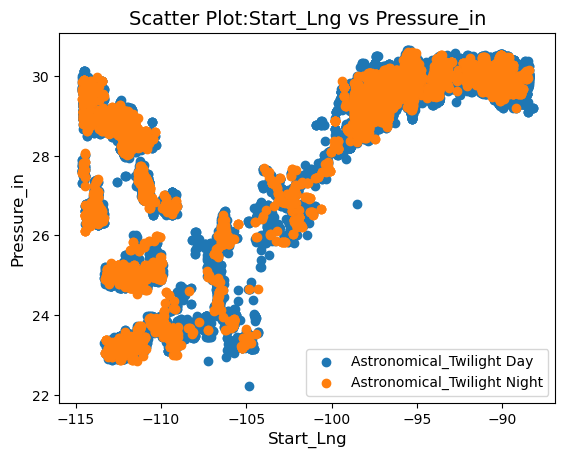

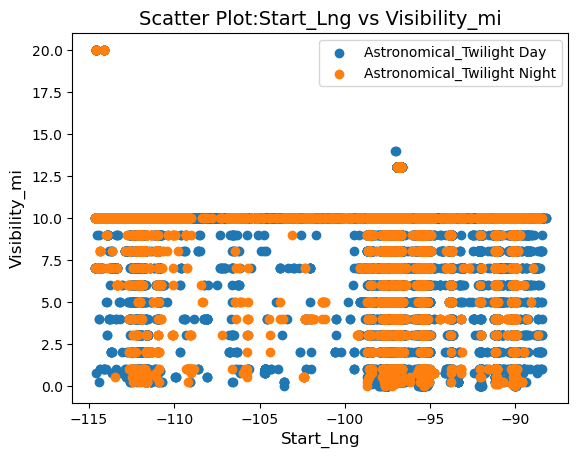

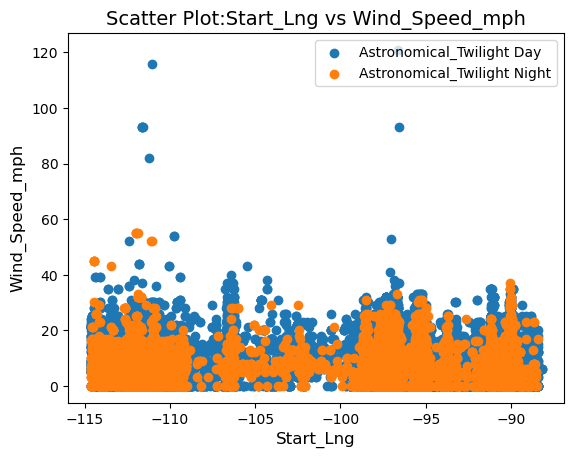

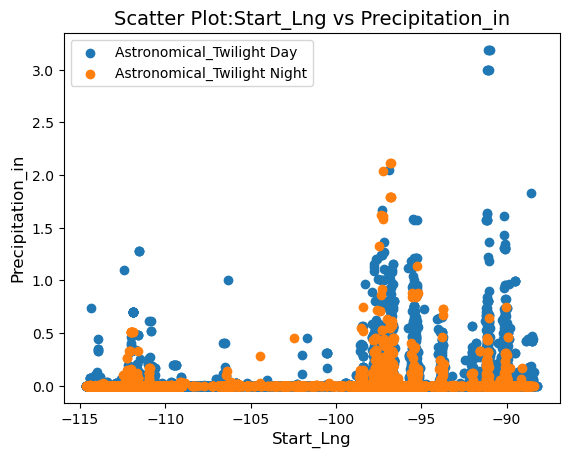

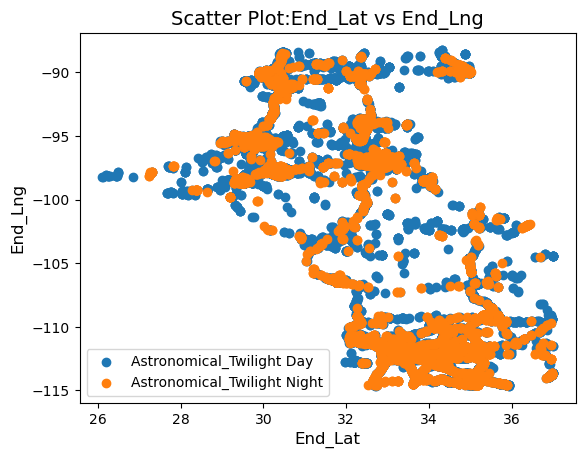

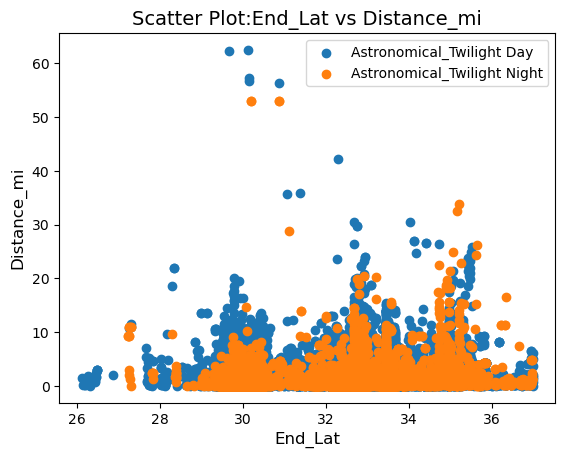

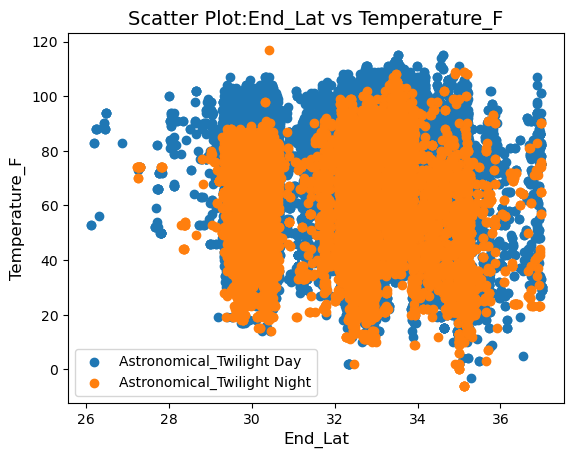

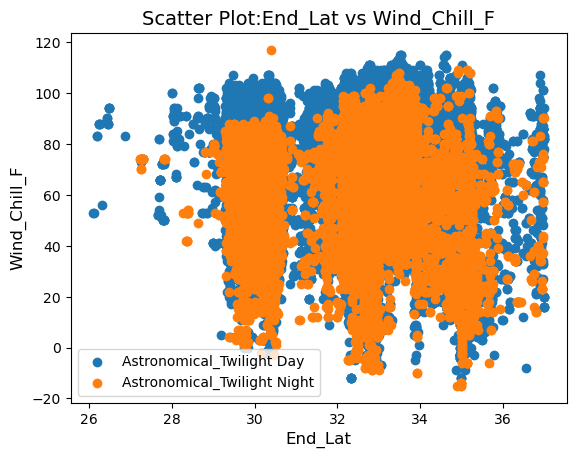

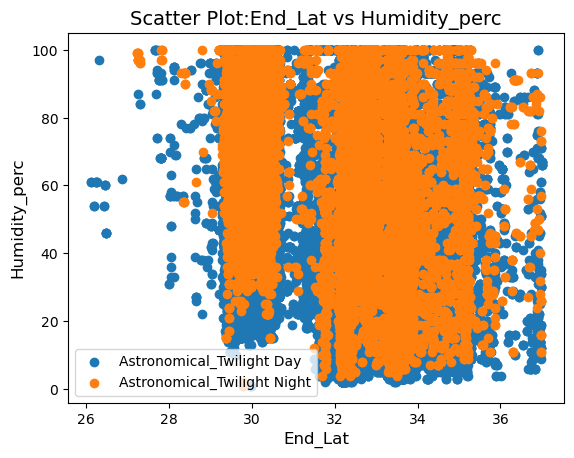

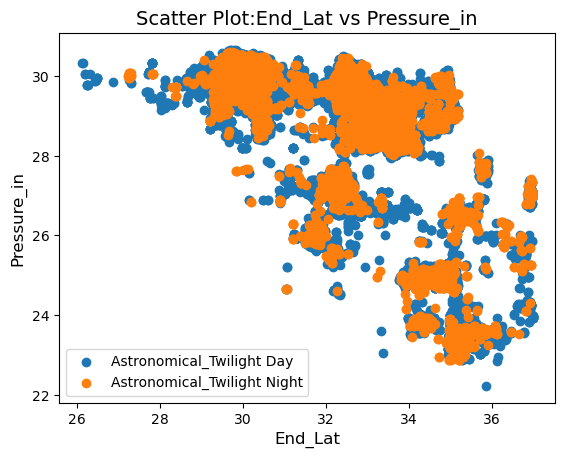

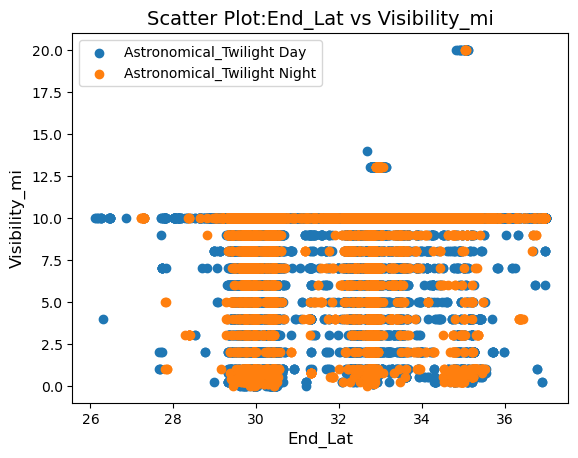

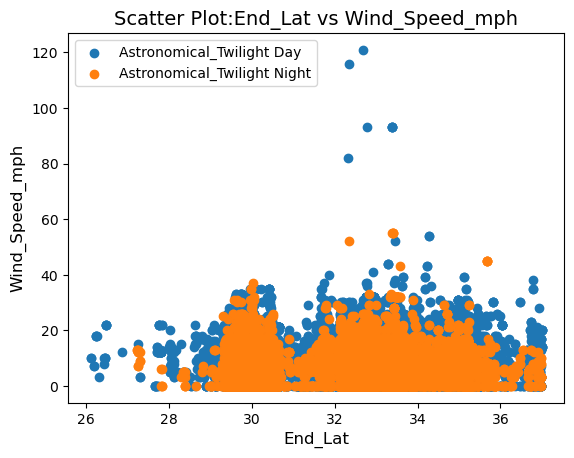

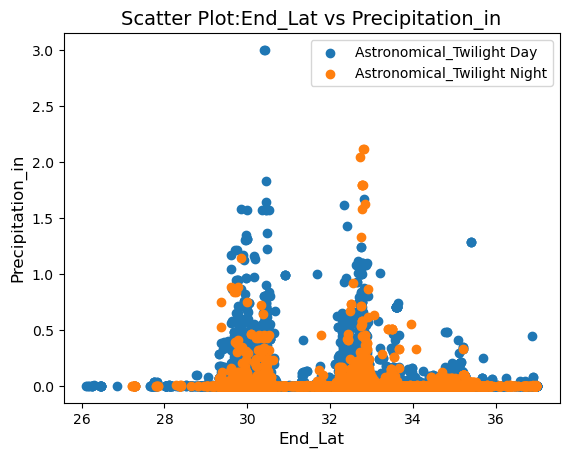

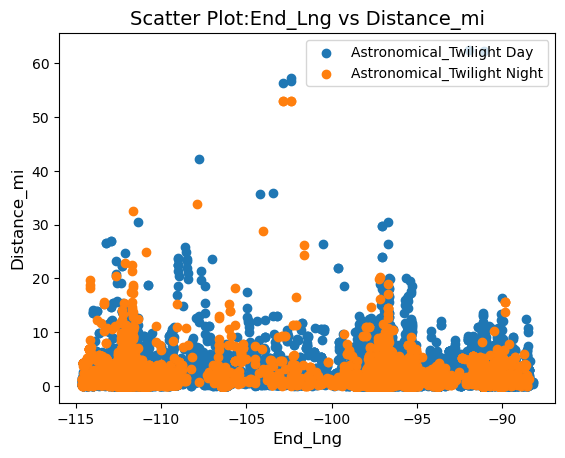

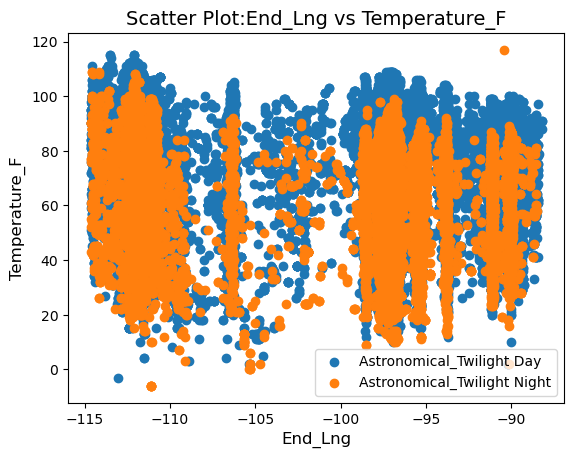

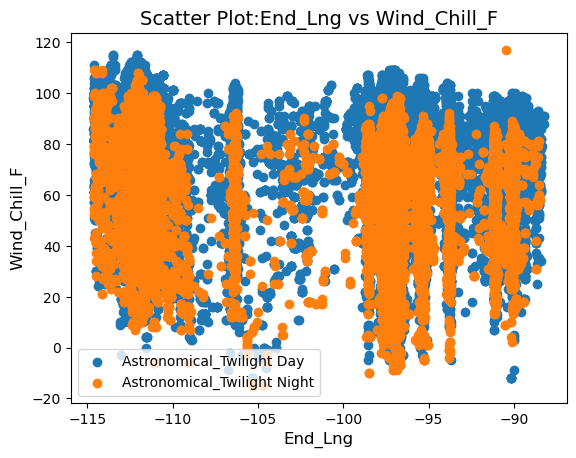

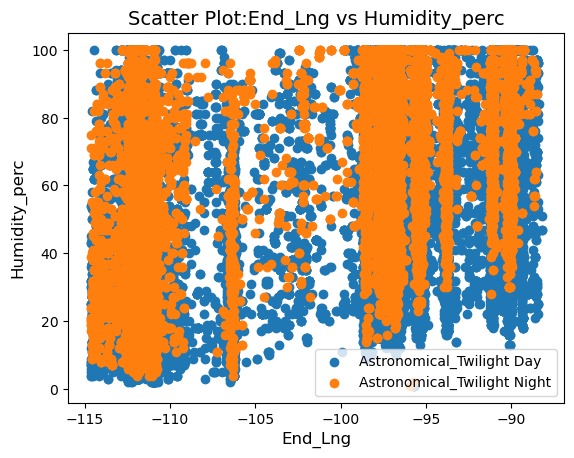

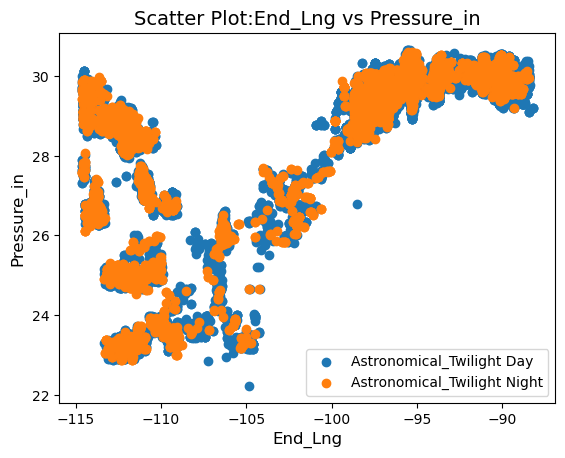

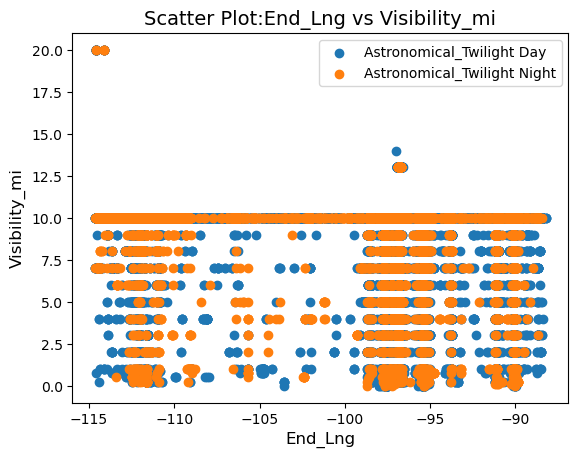

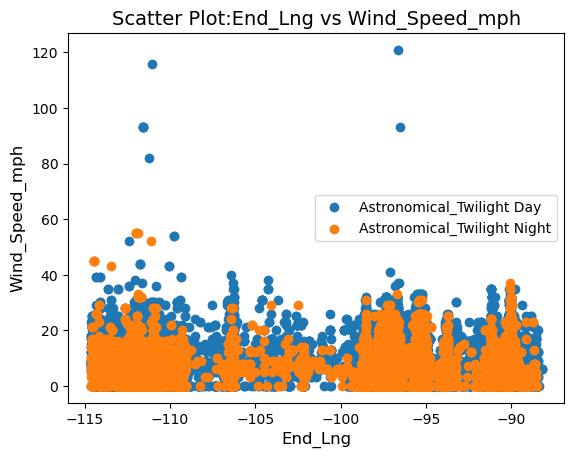

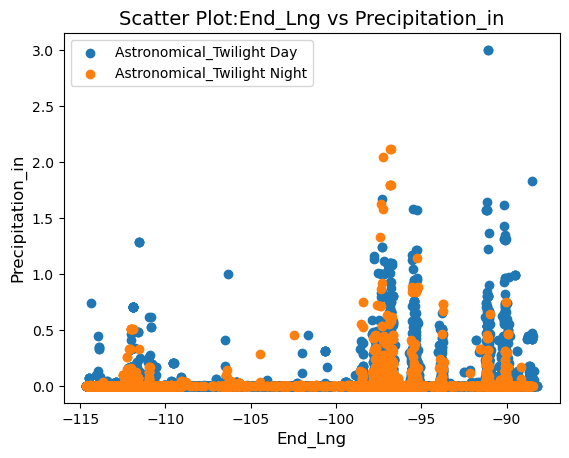

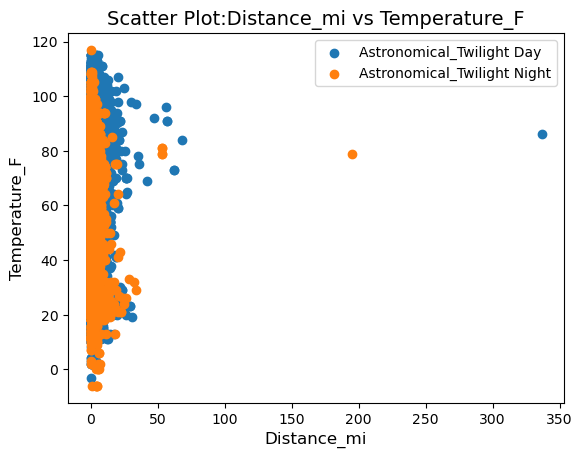

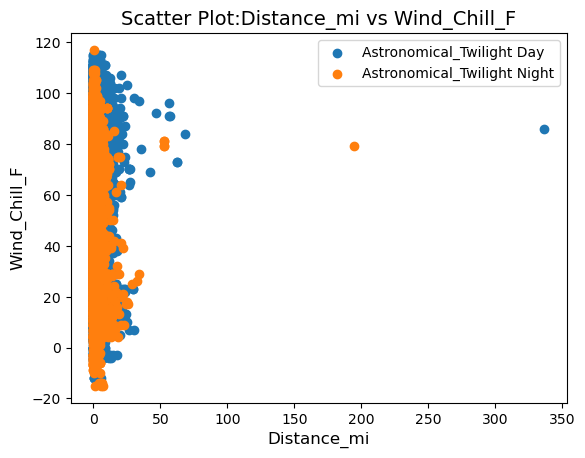

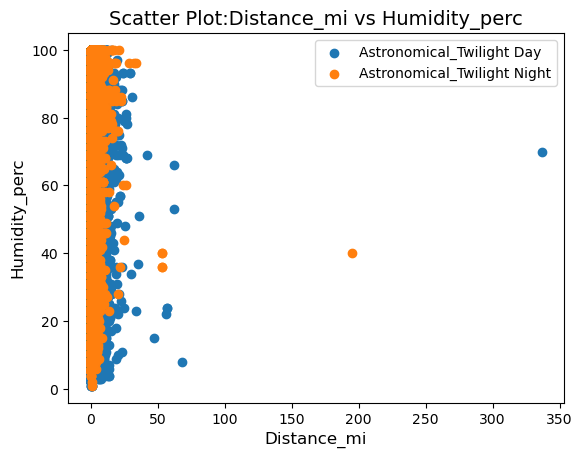

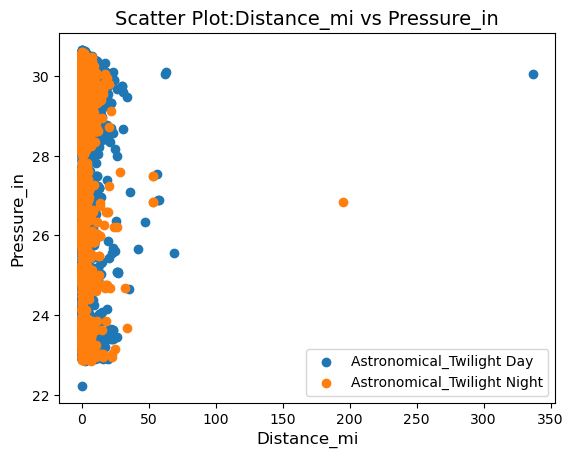

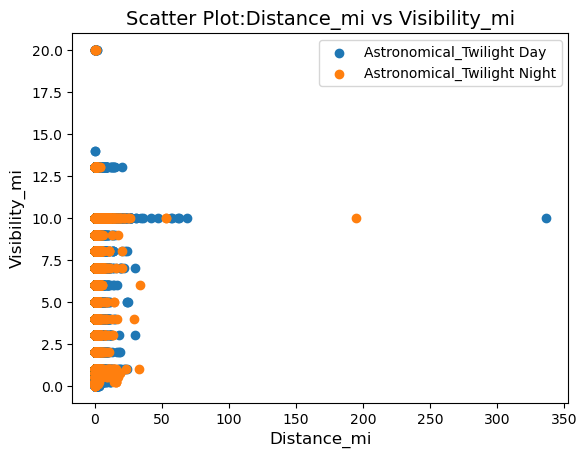

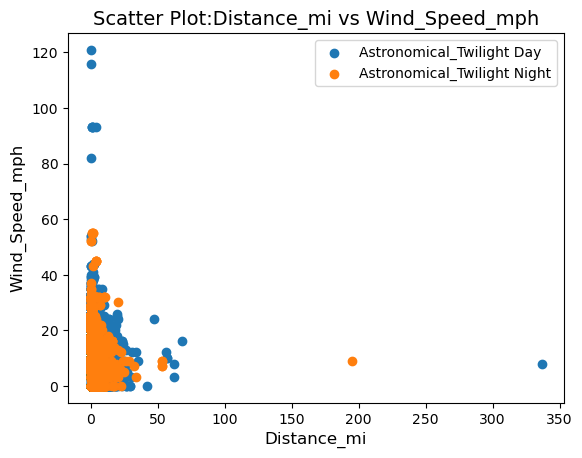

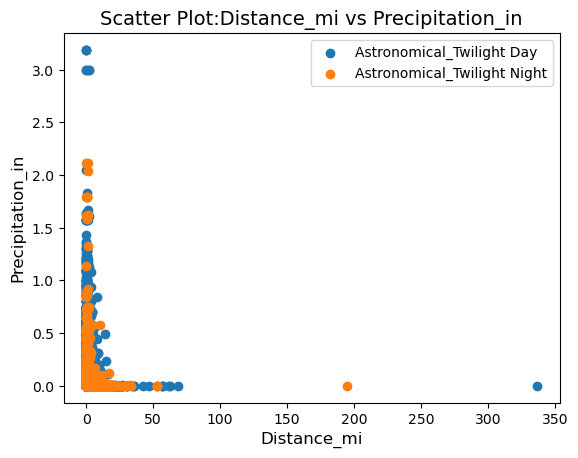

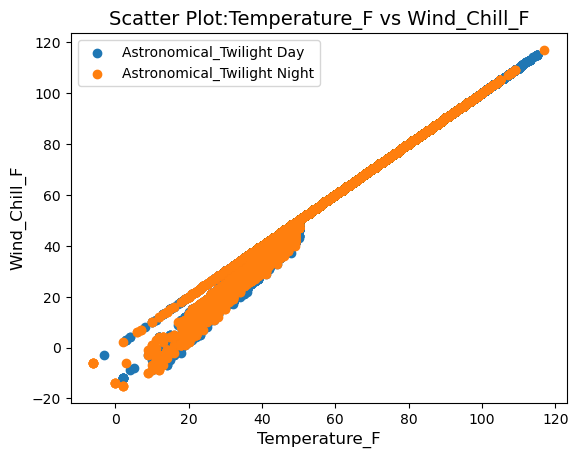

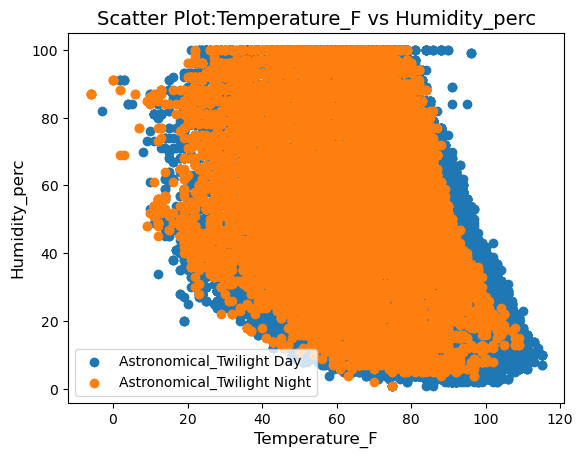

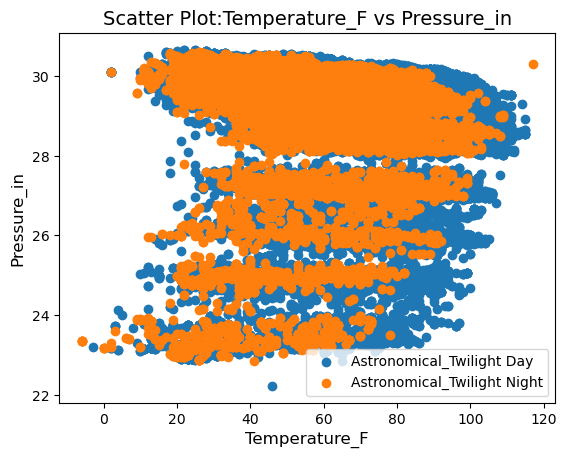

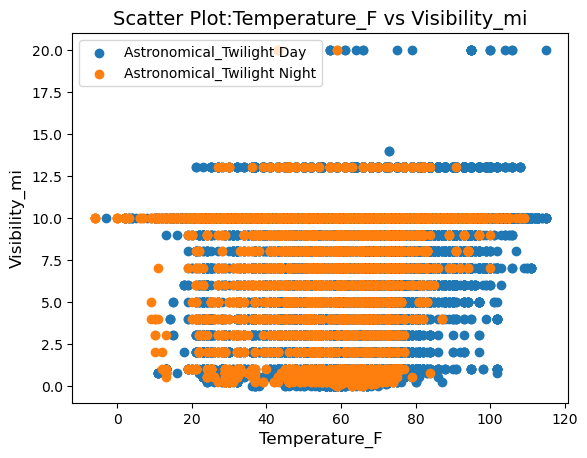

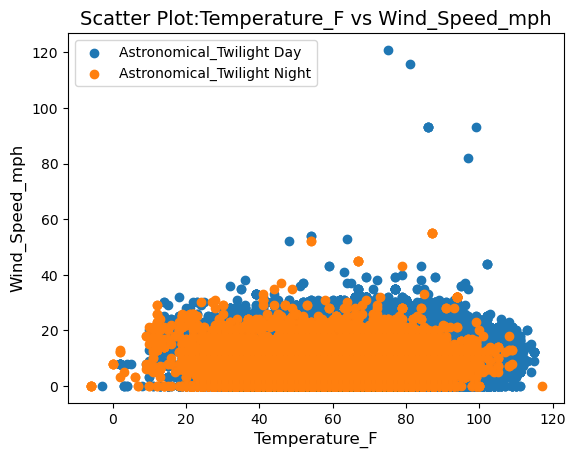

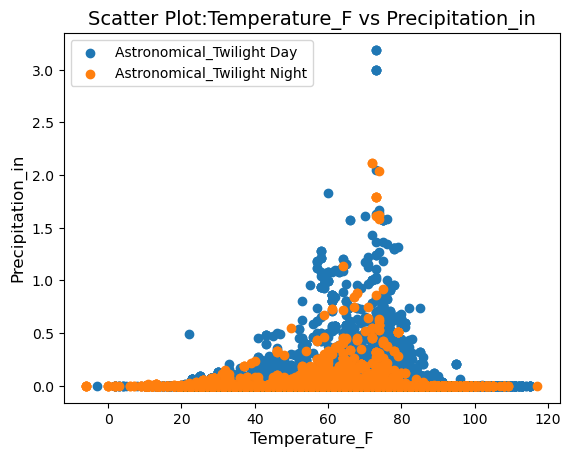

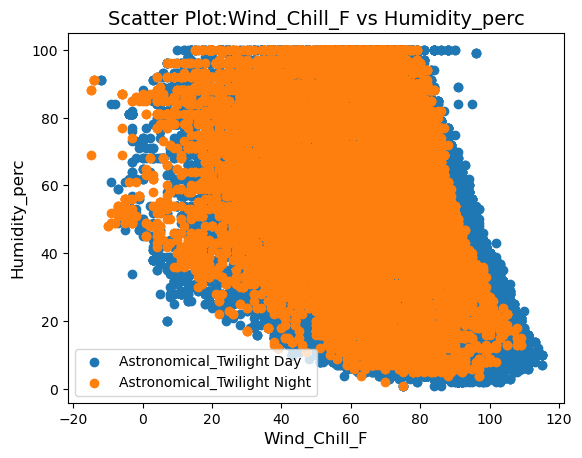

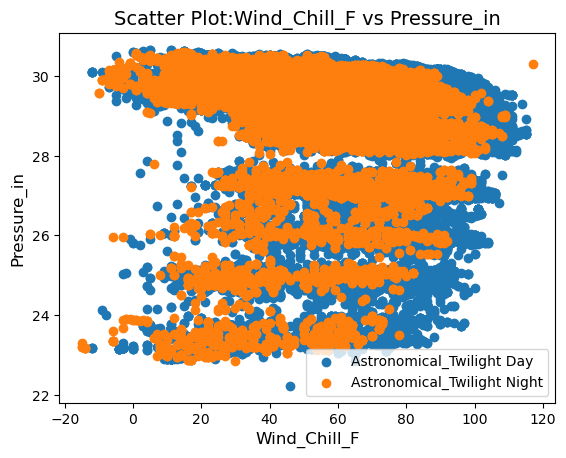

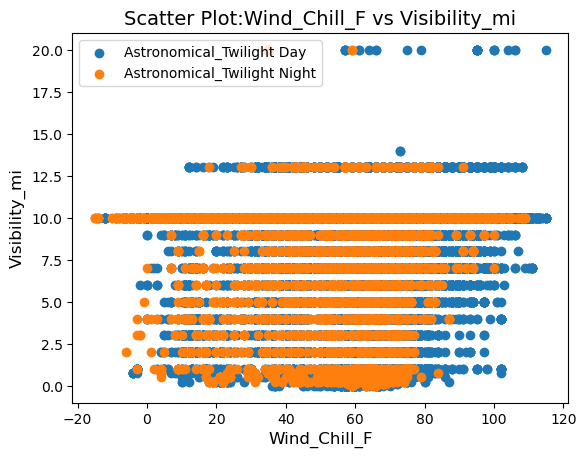

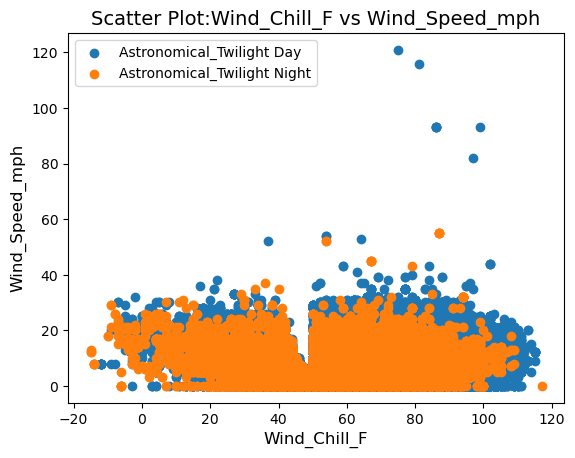

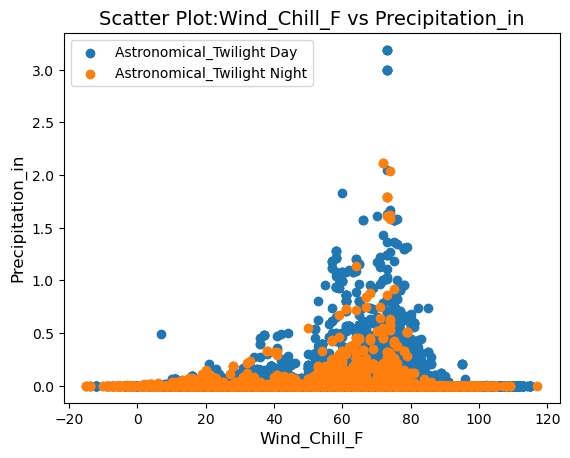

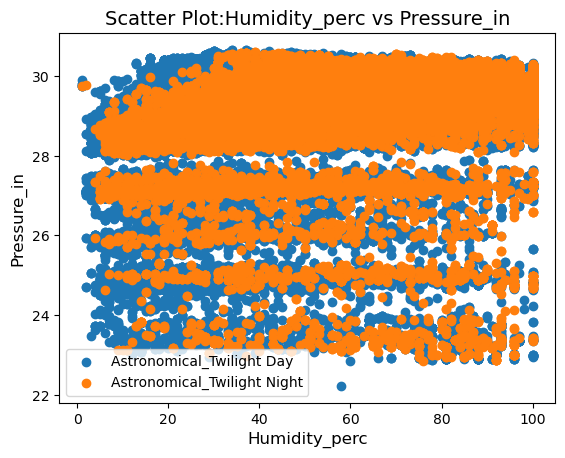

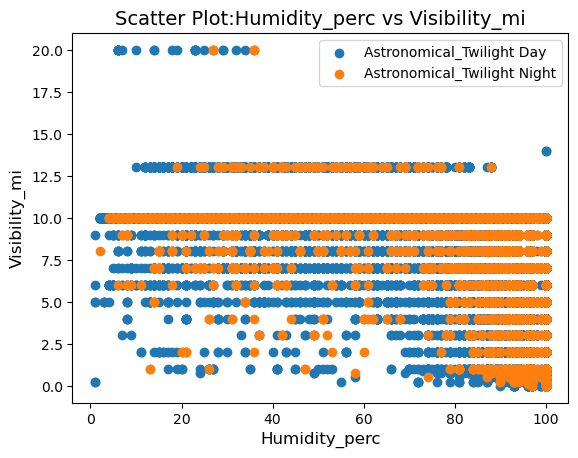

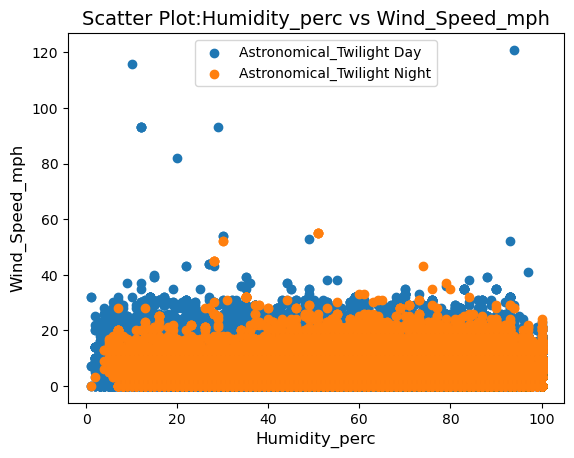

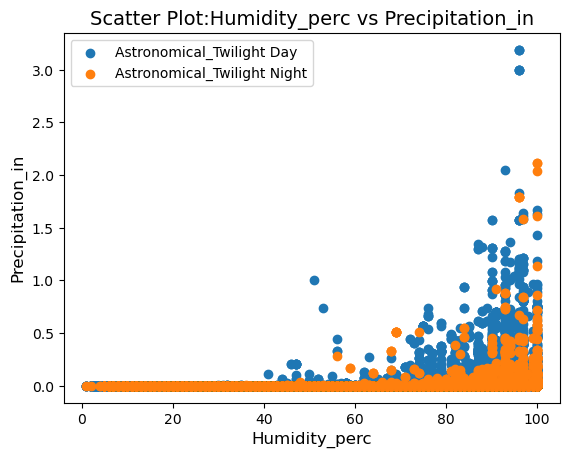

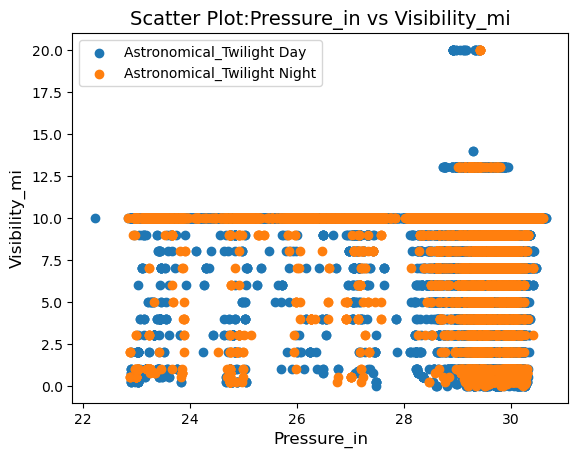

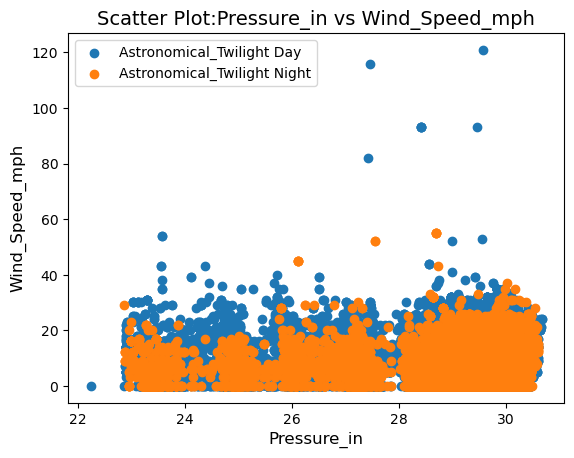

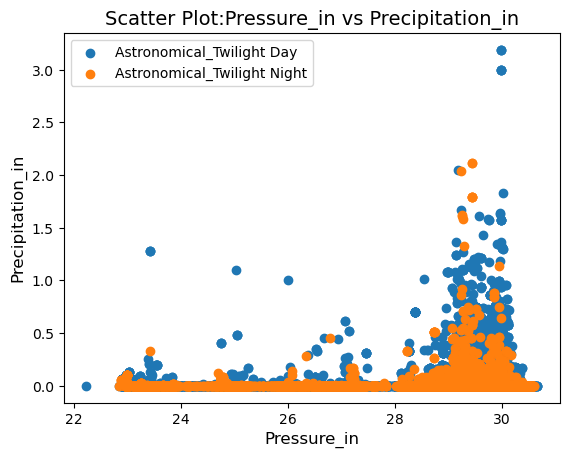

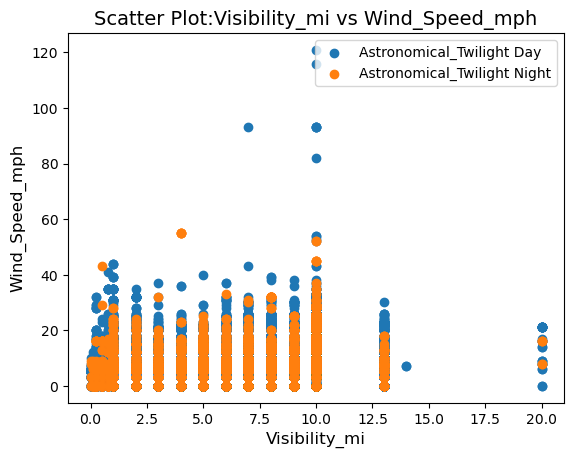

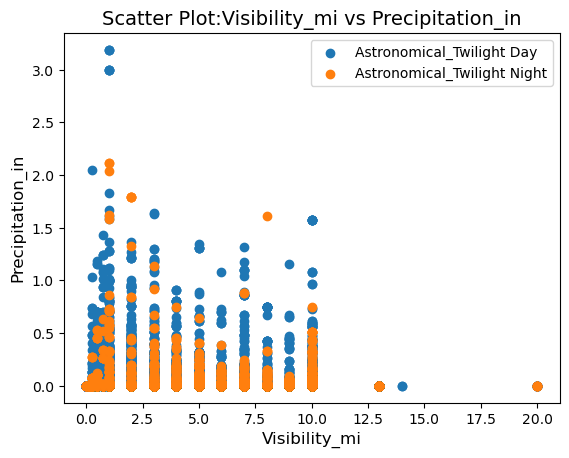

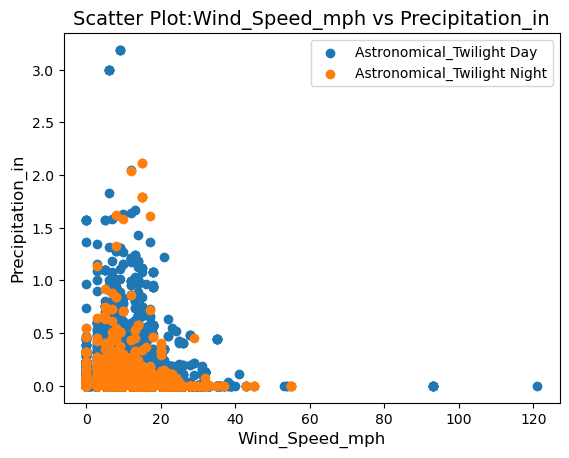

In [74]:
unique_twilight =['Day','Night']
i=0
for el1 in continuos_features:
    for el2 in continuos_features[i+1:]:
        for twilight_val in unique_twilight:
            data = df.filter(df['Astronomical_Twilight'] == twilight_val).select(el1, el2).dropna().collect()
            x = [row[el1] for row in data]
            y = [row[el2] for row in data]

            plt.scatter(x, y, label=f'Astronomical_Twilight {twilight_val}')

        plt.xlabel(el1, size=12)
        plt.ylabel(el2, size=12)
        plt.title('Scatter Plot:'+el1+ ' vs '+ el2, size=14)
        plt.legend()
        plt.show()
    i+=1


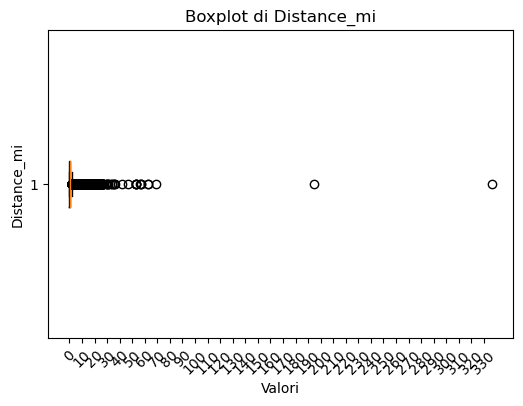

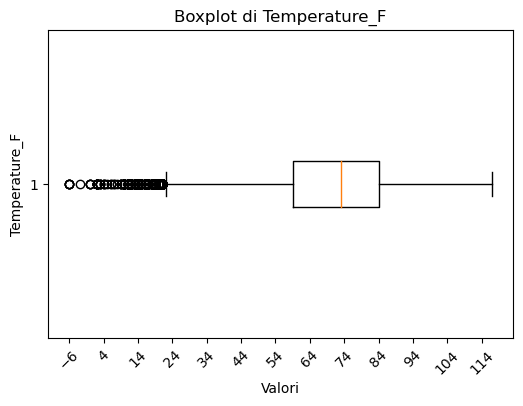

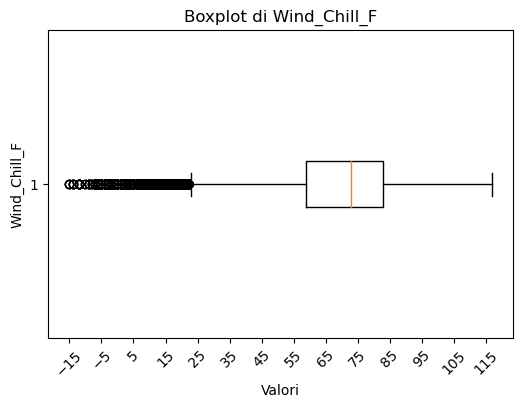

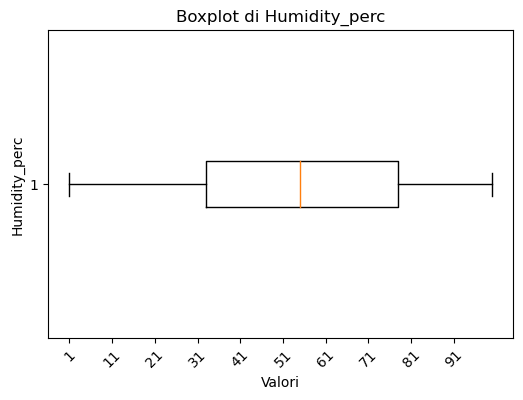

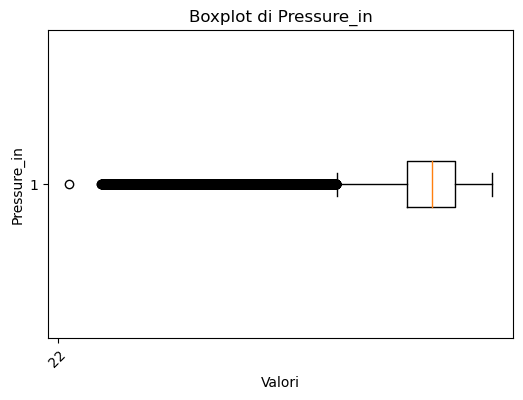

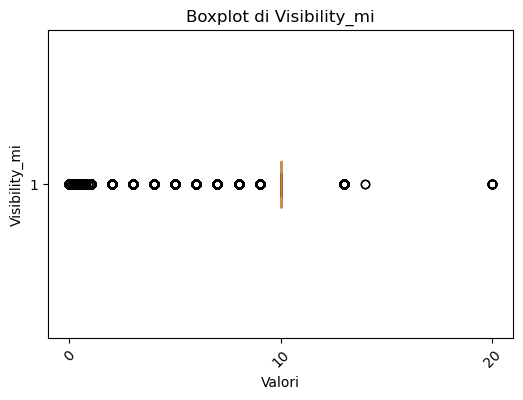

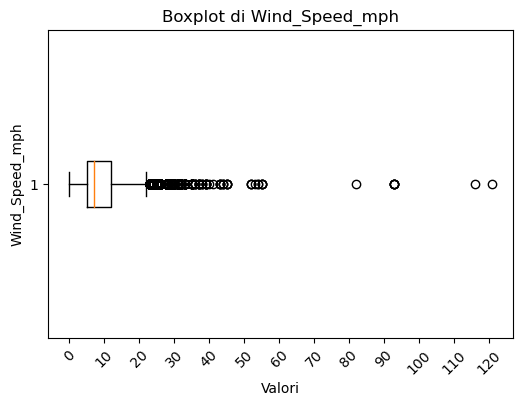

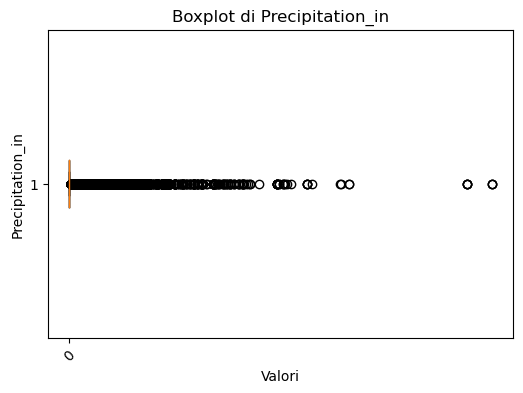

[['Numero outlier per Distance_mi 18604'], ['Numero outlier per Temperature_F 538'], ['Numero outlier per Wind_Chill_F 2742'], ['Numero outlier per Humidity_perc 0'], ['Numero outlier per Pressure_in 18765'], ['Numero outlier per Visibility_mi 22245'], ['Numero outlier per Wind_Speed_mph 2286'], ['Numero outlier per Precipitation_in 7667']]


In [75]:
df.createOrReplaceTempView("df")
outliers_list=[]
for col in continuos_features: 
    df_filtered = df.filter(df[col].isNotNull())
    percentiles = df_filtered.approxQuantile(col, [0.25, 0.5, 0.75], 0.01)
    Q1, median, Q3 = percentiles
    IQR=Q3-Q1
    W1=Q1-1.5*IQR
    W3=Q3+1.5*IQR
    query=""" SELECT """+ col + """ FROM df WHERE """ + col + """<""" + str(W1) +""" OR """+ col + """>""" + str(W3)
    outliers=sqlCtx.sql(query)
    numero_outliers=outliers.count()
    outliers_list.append(['Numero outlier per '+ col+' '+str(numero_outliers)])
    min_Query=""" SELECT MIN("""+col+""") AS Min FROM df """
    min_=sqlCtx.sql(min_Query)
    min_=min_.select('Min').rdd.flatMap(lambda x: x).collect()[0]
    max_Query=""" SELECT MAX("""+col+""") AS Max FROM df """
    max_=sqlCtx.sql(max_Query)
    max_=max_.select('Max').rdd.flatMap(lambda x: x).collect()[0]
    plt.figure(figsize=(6, 4))
    plt.boxplot([df_filtered.select(col).rdd.flatMap(lambda x: x).collect()], vert=False)
    plt.title('Boxplot di {}'.format(col))
    plt.xlabel('Valori')
    plt.ylabel('{}'.format(col))
    #plt.xticks([W1, Q1, median, Q3,W3], ['W1', 'Q1', 'Median', 'Q3', 'W3'])
    plt.xticks(range(int(min_),int(max_)+1,10), rotation=45)
    plt.show()
print(outliers_list)

# MISSING VALUES

### ASTRONOMICAL TWILIGHT

In [104]:
from pyspark.sql.functions import col
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.functions import  month, hour

In [9]:
df=df.withColumn("month", month("Start_Time"))

In [10]:
def season(month_):
    if month_>=3 and month_<=5:
        return 'Spring'
    elif month_>=6 and month_<=8:
        return 'Summer'
    elif month_>=9 and month_<=11:
        return 'Autumn'
    else:
        return 'Winter'

In [11]:
udf_season = udf(season, StringType())

In [14]:
df = df.withColumn("season", udf_season(col('month')))

In [15]:
df.take(4)

[Row(Severity=1, Start_Time=datetime.datetime(2022, 9, 8, 4, 14, 17), Distance_mi=0.0, City='Austin', County='Travis', State='TX', Temperature_F=71.0, Wind_Chill_F=71.0, Humidity_perc=96.0, Pressure_in=29.33, Visibility_mi=10.0, Wind_Direction='CALM', Wind_Speed_mph=0.0, Precipitation_in=0.0, Weather_Condition='Fair', Amenity=False, Bump=False, Crossing=False, Give_Way=False, Junction=False, No_Exit=False, Railway=False, Roundabout=False, Station=False, Stop=False, Traffic_Calming=False, Traffic_Signal=False, Turning_Loop=False, Astronomical_Twilight='Night', month=9, season='Autumn'),
 Row(Severity=1, Start_Time=datetime.datetime(2022, 9, 8, 5, 23, 55), Distance_mi=0.0, City='Austin', County='Travis', State='TX', Temperature_F=69.0, Wind_Chill_F=69.0, Humidity_perc=100.0, Pressure_in=29.32, Visibility_mi=8.0, Wind_Direction='CALM', Wind_Speed_mph=0.0, Precipitation_in=0.0, Weather_Condition='Fair', Amenity=False, Bump=False, Crossing=False, Give_Way=False, Junction=False, No_Exit=Fals

In [19]:
def fill_astronomical_twilight(season,date, astro): 
    if astro is None:
        hour_=date.hour
        if season=='Spring':
            if hour_>=6 and hour_<=19:
                return 'Day'
            else:
                return 'Night'
        elif season=='Summer':
            if hour_>=5 and hour_<=21:
                return 'Day'
            else:
                return 'Night'
        elif season=='Autumn':
            if hour_>=6 and hour_<=18:
                return 'Day'
            else:
                return 'Night'
        else:
            if hour_>=7 and hour_<=17:
                return 'Day'
            else:
                return 'Night'
    else: 
        return astro

In [20]:
udf_fill_astronomical_twilight = udf(fill_astronomical_twilight, StringType())

In [21]:
df = df.withColumn("Astronomical_Twilight_full", udf_fill_astronomical_twilight(col('season'),col('Start_Time'),col("Astronomical_Twilight")))

In [22]:
df=df.drop('Astronomical_Twilight') # elimino la vecchia colonna con in NULL
df=df.withColumnRenamed("Astronomical_Twilight_full", "Astronomical_Twilight") #rinomino la colonna con missing value

In [96]:
df.createOrReplaceTempView("missingAss")
query = spark.sql('SELECT Astronomical_Twilight_full,Astronomical_Twilight FROM missingAss m WHERE m.Astronomical_Twilight IS NULL') 
query.show()

+--------------------------+---------------------+
|Astronomical_Twilight_full|Astronomical_Twilight|
+--------------------------+---------------------+
|                       Day|                 NULL|
|                       Day|                 NULL|
|                       Day|                 NULL|
|                       Day|                 NULL|
|                       Day|                 NULL|
|                       Day|                 NULL|
|                       Day|                 NULL|
|                       Day|                 NULL|
|                       Day|                 NULL|
|                       Day|                 NULL|
|                       Day|                 NULL|
|                     Night|                 NULL|
|                       Day|                 NULL|
|                       Day|                 NULL|
|                       Day|                 NULL|
|                       Day|                 NULL|
|                       Day|   

estate
estate
estate
estate
estate
estate
estate
estate
estate
estate
estate
autunno
estate
estate
autunno
estate
estate
estate
estate
estate
estate


In [23]:
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull(c), c)).alias(c) for c in df.columns])
missing.toPandas().T

23/11/30 15:40:53 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


0
Severity                  0
Start_Time                0
Start_Lat                 0
Start_Lng                 0
Distance_mi               0
City                      0
County                    0
State                     0
Temperature_F          1431
Wind_Chill_F           2982
Humidity_perc          1578
Pressure_in            1179
Visibility_mi          1447
Wind_Direction         2725
Wind_Speed_mph         2725
Precipitation_in       4874
Weather_Condition      1721
Amenity                   0
Bump                      0
Crossing                  0
Give_Way                  0
Junction                  0
No_Exit                   0
Railway                   0
Roundabout                0
Station                   0
Stop                      0
Traffic_Calming           0
Traffic_Signal            0
day_of_the_week           0
month                     0
hour                      0
season                    0
Astronomical_Twilight     0

## TEMPERATURE

In [24]:
import pyspark.sql.functions as F
from pyspark.sql import Window

window = Window.partitionBy(["County", "Astronomical_Twilight","season"]).orderBy("County", "Astronomical_Twilight","season")

In [25]:
tmpdf = df.withColumn("avg", F.avg("Temperature_F").over(window))

In [26]:
tmpdf2 = tmpdf.withColumn("Temperature_F", 
                         F.when(F.col("Temperature_F").isNull(),
                                F.col("avg"))
                                .otherwise(F.col("Temperature_F")))

In [27]:
tmpdf3 = tmpdf2.drop("avg")

In [28]:
df = tmpdf3

In [28]:
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull(c), c)).alias(c) for c in df.columns])
missing.toPandas().T

0
Severity                  0
Start_Time                0
Distance_mi               0
City                      0
County                    0
State                     0
Temperature_F            48
Wind_Chill_F           2982
Humidity_perc          1578
Pressure_in            1179
Visibility_mi          1447
Wind_Direction         2725
Wind_Speed_mph         2725
Precipitation_in       4874
Weather_Condition      1721
Amenity                   0
Bump                      0
Crossing                  0
Give_Way                  0
Junction                  0
No_Exit                   0
Railway                   0
Roundabout                0
Station                   0
Stop                      0
Traffic_Calming           0
Traffic_Signal            0
Turning_Loop              0
month                     0
season                    0
Astronomical_Twilight     0

Se da sopra rimangono ancora dei missing values, rifaccio lo stesso procedimento estendendo su State

In [29]:
import pyspark.sql.functions as F
from pyspark.sql import Window

window = Window.partitionBy(["State", "Astronomical_Twilight","season"]).orderBy("State", "Astronomical_Twilight","season")

In [30]:
tmpdf = df.withColumn("avg", F.avg("Temperature_F").over(window))

In [31]:
tmpdf2 = tmpdf.withColumn("Temperature_F", 
                         F.when(F.col("Temperature_F").isNull(),
                                F.col("avg"))
                                .otherwise(F.col("Temperature_F")))

In [32]:
tmpdf3 = tmpdf2.drop("avg")

In [33]:
df=tmpdf3

In [34]:
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Temperature_F"), "Temperature_F")).alias("Temperature_F")])
missing.toPandas().T

0
Temperature_F  0

## WIND_CHILL

In [35]:
import pyspark.sql.functions as F
from pyspark.sql import Window

window = Window.partitionBy(["County","season","Astronomical_Twilight"]).orderBy("County","season", "Astronomical_Twilight")

In [36]:
tmpdf = df.withColumn("avg", F.avg("Wind_Chill_F").over(window))

In [37]:
tmpdf2 = tmpdf.withColumn("Wind_Chill_F", 
                         F.when(F.col("Wind_Chill_F").isNull(),
                                F.col("avg"))
                                .otherwise(F.col("Wind_Chill_F")))

In [38]:
tmpdf3 = tmpdf2.drop("avg")

In [39]:
df=tmpdf3

In [40]:
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Wind_Chill_F"), "Wind_Chill_F")).alias("Wind_Chill_F")])
missing.toPandas().T

0
Wind_Chill_F  64

Se da sopra rimangono missing values, mi estendo a State

In [41]:
import pyspark.sql.functions as F
from pyspark.sql import Window

window = Window.partitionBy(["State","season", "Astronomical_Twilight"]).orderBy("State", "season", "Astronomical_Twilight")

In [42]:
tmpdf = df.withColumn("avg", F.avg("Wind_Chill_F").over(window))

In [43]:
tmpdf2 = tmpdf.withColumn("Wind_Chill_F", 
                         F.when(F.col("Wind_Chill_F").isNull(),
                                F.col("avg"))
                                .otherwise(F.col("Wind_Chill_F")))

In [44]:
tmpdf3 = tmpdf2.drop("avg")

In [45]:
df=tmpdf3

In [46]:
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Wind_Chill_F"), "Wind_Chill_F")).alias("Wind_Chill_F")])
missing.toPandas().T

0
Wind_Chill_F  0

## Humidity_perc

In [47]:
import pyspark.sql.functions as F
from pyspark.sql import Window

window = Window.partitionBy(["County", "Astronomical_Twilight","season"]).orderBy("County", "Astronomical_Twilight","season")

In [48]:
tmpdf = df.withColumn("avg", F.avg("Humidity_perc").over(window))

In [49]:
tmpdf2 = tmpdf.withColumn("Humidity_perc", 
                         F.when(F.col("Humidity_perc").isNull(),
                                F.col("avg"))
                                .otherwise(F.col("Humidity_perc")))

In [50]:
tmpdf3 = tmpdf2.drop("avg")

In [51]:
df=tmpdf3

In [56]:
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Humidity_perc"), "Humidity_perc")).alias("Humidity_perc")])
missing.toPandas().T

0
Humidity_perc  50

Se da sopra rimangono missing values, mi estendo a State

In [52]:
import pyspark.sql.functions as F
from pyspark.sql import Window

window = Window.partitionBy(["County","season"]).orderBy("County","season")

In [53]:
tmpdf = df.withColumn("avg", F.avg("Humidity_perc").over(window))

In [54]:
tmpdf2 = tmpdf.withColumn("Humidity_perc", 
                         F.when(F.col("Humidity_perc").isNull(),
                                F.col("avg"))
                                .otherwise(F.col("Humidity_perc")))

In [55]:
tmpdf3 = tmpdf2.drop("avg")

In [56]:
df=tmpdf3

In [57]:
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Humidity_perc"), "Humidity_perc")).alias("Humidity_perc")])
missing.toPandas().T

0
Humidity_perc  38

In [58]:
import pyspark.sql.functions as F
from pyspark.sql import Window

window = Window.partitionBy(["State","season"]).orderBy("State","season")

In [59]:
tmpdf = df.withColumn("avg", F.avg("Humidity_perc").over(window))

In [60]:
tmpdf2 = tmpdf.withColumn("Humidity_perc", 
                         F.when(F.col("Humidity_perc").isNull(),
                                F.col("avg"))
                                .otherwise(F.col("Humidity_perc")))

In [61]:
tmpdf3 = tmpdf2.drop("avg")

In [62]:
df=tmpdf3

In [63]:
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Humidity_perc"), "Humidity_perc")).alias("Humidity_perc")])
missing.toPandas().T

0
Humidity_perc  0

## Wind Direction

In [64]:
import pyspark.sql.functions as F
from pyspark.sql import Window

window = Window.partitionBy(["County", "Wind_Chill_F","season"]).orderBy("County", "Wind_Chill_F","season")

In [65]:
tmpdf = df.withColumn("mode", F.mode("Wind_Direction").over(window))

In [66]:
tmpdf2 = tmpdf.withColumn("Wind_Direction", 
                         F.when(F.col("Wind_Direction").isNull(),
                                F.col("mode"))
                                .otherwise(F.col("Wind_Direction")))

In [67]:
tmpdf3 = tmpdf2.drop("mode")

In [68]:
df=tmpdf3

In [60]:
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Wind_Direction"), "Wind_Direction")).alias("Wind_Direction")])
missing.toPandas().T

0
Humidity_perc  49

Se da sopra rimangono missing values, mi estendo a State

In [69]:
window = Window.partitionBy(["State", "Wind_Chill_F","season"]).orderBy("State", "Wind_Chill_F","season")

In [70]:
tmpdf = df.withColumn("mode", F.mode("Wind_Direction").over(window))

In [71]:
tmpdf2 = tmpdf.withColumn("Wind_Direction", 
                         F.when(F.col("Wind_Direction").isNull(),
                                F.col("mode"))
                                .otherwise(F.col("Wind_Direction")))

In [72]:
tmpdf3 = tmpdf2.drop("mode")

In [73]:
df=tmpdf3

In [74]:
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Wind_Direction"), "Wind_Direction")).alias("Wind_Direction")])
missing.toPandas().T

0
Wind_Direction  1924

In [75]:
window = Window.partitionBy(["County","season"]).orderBy("County","season")

In [76]:
tmpdf = df.withColumn("mode", F.mode("Wind_Direction").over(window))

In [77]:
tmpdf2 = tmpdf.withColumn("Wind_Direction", 
                         F.when(F.col("Wind_Direction").isNull(),
                                F.col("mode"))
                                .otherwise(F.col("Wind_Direction")))

In [78]:
tmpdf3 = tmpdf2.drop("mode")

In [79]:
df=tmpdf3

In [80]:
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Wind_Direction"), "Wind_Direction")).alias("Wind_Direction")])
missing.toPandas().T

0
Wind_Direction  42

In [81]:
window = Window.partitionBy(["State","season"]).orderBy("State","season")

In [82]:
tmpdf = df.withColumn("mode", F.mode("Wind_Direction").over(window))

In [83]:
tmpdf2 = tmpdf.withColumn("Wind_Direction", 
                         F.when(F.col("Wind_Direction").isNull(),
                                F.col("mode"))
                                .otherwise(F.col("Wind_Direction")))

In [84]:
tmpdf3 = tmpdf2.drop("mode")

In [85]:
df=tmpdf3

In [86]:
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Wind_Direction"), "Wind_Direction")).alias("Wind_Direction")])
missing.toPandas().T

0
Wind_Direction  0

## Wind Speed

In [87]:
import pyspark.sql.functions as F
from pyspark.sql import Window

window = Window.partitionBy(["County", "Wind_Chill_F","season"]).orderBy("County", "Wind_Chill_F","season")

In [88]:
tmpdf = df.withColumn("avg", F.mode("Wind_Speed_mph").over(window))

In [89]:
tmpdf2 = tmpdf.withColumn("Wind_Speed_mph", 
                         F.when(F.col("Wind_Speed_mph").isNull(),
                                F.col("avg"))
                                .otherwise(F.col("Wind_Speed_mph")))

In [90]:
tmpdf3 = tmpdf2.drop("avg")

In [91]:
df=tmpdf3

In [92]:
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Wind_Speed_mph"), "Wind_Speed_mph")).alias("Wind_Speed_mph")])
missing.toPandas().T

0
Wind_Speed_mph  1937

Se da sopra rimangono missing values, mi estendo a State

In [93]:
window = Window.partitionBy(["State", "Wind_Chill_F","season"]).orderBy("State", "Wind_Chill_F","season")

In [94]:
tmpdf = df.withColumn("avg", F.mode("Wind_Speed_mph").over(window))

In [95]:
tmpdf2 = tmpdf.withColumn("Wind_Speed_mph", 
                         F.when(F.col("Wind_Speed_mph").isNull(),
                                F.col("avg"))
                                .otherwise(F.col("Wind_Speed_mph")))

In [96]:
tmpdf3 = tmpdf2.drop("avg")

In [97]:
df=tmpdf3

In [98]:
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Wind_Speed_mph"), "Wind_Speed_mph")).alias("Wind_Speed_mph")])
missing.toPandas().T

0
Wind_Speed_mph  1924

In [99]:
window = Window.partitionBy(["County","season"]).orderBy("County","season")

In [100]:
tmpdf = df.withColumn("avg", F.mode("Wind_Speed_mph").over(window))

In [101]:
tmpdf2 = tmpdf.withColumn("Wind_Speed_mph", 
                         F.when(F.col("Wind_Speed_mph").isNull(),
                                F.col("avg"))
                                .otherwise(F.col("Wind_Speed_mph")))

In [102]:
tmpdf3 = tmpdf2.drop("avg")

In [103]:
df=tmpdf3

In [104]:
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Wind_Speed_mph"), "Wind_Speed_mph")).alias("Wind_Speed_mph")])
missing.toPandas().T

0
Wind_Speed_mph  42

In [105]:
window = Window.partitionBy(["State","season"]).orderBy("State","season")

In [106]:
tmpdf = df.withColumn("avg", F.mode("Wind_Speed_mph").over(window))

In [107]:
tmpdf2 = tmpdf.withColumn("Wind_Speed_mph", 
                         F.when(F.col("Wind_Speed_mph").isNull(),
                                F.col("avg"))
                                .otherwise(F.col("Wind_Speed_mph")))

In [108]:
tmpdf3 = tmpdf2.drop("avg")

In [109]:
df=tmpdf3

In [110]:
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Wind_Speed_mph"), "Wind_Speed_mph")).alias("Wind_Speed_mph")])
missing.toPandas().T

0
Wind_Speed_mph  0

## Precipitation_in

In [111]:
import pyspark.sql.functions as F
from pyspark.sql import Window

window = Window.partitionBy(["City","month"]).orderBy("City", "month")

In [112]:
tmpdf = df.withColumn("mode", F.mode("Precipitation_in").over(window))

In [113]:
tmpdf2 = tmpdf.withColumn("Precipitation_in", 
                         F.when(F.col("Precipitation_in").isNull(),
                                F.col("mode"))
                                .otherwise(F.col("Precipitation_in")))

In [114]:
tmpdf3 = tmpdf2.drop("mode")

In [115]:
df=tmpdf3

In [116]:
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Precipitation_in"), "Precipitation_in")).alias("Precipitation_in")])
missing.toPandas().T

0
Precipitation_in  2501

Se da sopra rimangono missing values, mi estendo a State

In [117]:
import pyspark.sql.functions as F
from pyspark.sql import Window

window = Window.partitionBy(["County","month"]).orderBy("County", "month")

In [118]:
tmpdf = df.withColumn("mode", F.mode("Precipitation_in").over(window))

In [119]:
tmpdf2 = tmpdf.withColumn("Precipitation_in", 
                         F.when(F.col("Precipitation_in").isNull(),
                                F.col("mode"))
                                .otherwise(F.col("Precipitation_in")))

In [120]:
tmpdf3 = tmpdf2.drop("mode")

In [121]:
df=tmpdf3

In [122]:
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Precipitation_in"), "Precipitation_in")).alias("Precipitation_in")])
missing.toPandas().T

0
Precipitation_in  124

In [123]:
import pyspark.sql.functions as F
from pyspark.sql import Window

window = Window.partitionBy(["County","season"]).orderBy("County", "season")

In [124]:
tmpdf = df.withColumn("mode", F.mode("Precipitation_in").over(window))

In [125]:
tmpdf2 = tmpdf.withColumn("Precipitation_in", 
                         F.when(F.col("Precipitation_in").isNull(),
                                F.col("mode"))
                                .otherwise(F.col("Precipitation_in")))

In [126]:
tmpdf3 = tmpdf2.drop("mode")

In [127]:
df=tmpdf3

In [128]:
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Precipitation_in"), "Precipitation_in")).alias("Precipitation_in")])
missing.toPandas().T

0
Precipitation_in  45

In [129]:
import pyspark.sql.functions as F
from pyspark.sql import Window

window = Window.partitionBy(["State","month"]).orderBy("State", "month")

In [130]:
tmpdf = df.withColumn("mode", F.mode("Precipitation_in").over(window))

In [131]:
tmpdf2 = tmpdf.withColumn("Precipitation_in", 
                         F.when(F.col("Precipitation_in").isNull(),
                                F.col("mode"))
                                .otherwise(F.col("Precipitation_in")))

In [132]:
tmpdf3 = tmpdf2.drop("mode")

In [133]:
df=tmpdf3

In [134]:
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Precipitation_in"), "Precipitation_in")).alias("Precipitation_in")])
missing.toPandas().T

0
Precipitation_in  0

## Weather_Condition

In [135]:
def fill_Weather_Condition(precipitation,temperature, weather): 
    if weather is None:
        if precipitation>0 and temperature>32:
            return 'Rain'
        elif precipitation>0 and temperature<=32:
            return 'Snow'
        else:
            return weather
    else: 
        return weather

In [136]:
udf_fill_Weather_Condition = udf(fill_Weather_Condition, StringType())

In [137]:
df = df.withColumn("Weather_Condition_full", fill_Weather_Condition(col('Precipitation_in'),col('Temperature_F'),col("Weather_Condition")))

In [138]:
df=df.drop('Weather_Condition') # elimino la vecchia colonna con in NULL
df=df.withColumnRenamed("Weather_Condition_full", "Weather_Condition") #rinomino la colonna con missing value

In [139]:
import pyspark.sql.functions as F
from pyspark.sql import Window

window = Window.partitionBy(["City","month"]).orderBy("City", "month")

In [140]:
tmpdf = df.withColumn("mode", F.mode("Weather_Condition").over(window))

In [141]:
tmpdf2 = tmpdf.withColumn("Weather_Condition", 
                         F.when(F.col("Weather_Condition").isNull(),
                                F.col("mode"))
                                .otherwise(F.col("Weather_Condition")))

In [142]:
tmpdf3 = tmpdf2.drop("mode")

In [143]:
df=tmpdf3

In [144]:
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Weather_Condition"), "Weather_Condition")).alias("Weather_Condition")])
missing.toPandas().T

0
Weather_Condition  649

In [145]:
import pyspark.sql.functions as F
from pyspark.sql import Window

window = Window.partitionBy(["County","month"]).orderBy("County", "month")

In [146]:
tmpdf = df.withColumn("mode", F.mode("Weather_Condition").over(window))

In [147]:
tmpdf2 = tmpdf.withColumn("Weather_Condition", 
                         F.when(F.col("Weather_Condition").isNull(),
                                F.col("mode"))
                                .otherwise(F.col("Weather_Condition")))

In [148]:
tmpdf3 = tmpdf2.drop("mode")

In [149]:
df=tmpdf3

In [150]:
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Weather_Condition"), "Weather_Condition")).alias("Weather_Condition")])
missing.toPandas().T

0
Weather_Condition  90

In [151]:
import pyspark.sql.functions as F
from pyspark.sql import Window

window = Window.partitionBy(["State","month"]).orderBy("State", "month")

In [152]:
tmpdf = df.withColumn("mode", F.mode("Weather_Condition").over(window))

In [153]:
tmpdf2 = tmpdf.withColumn("Weather_Condition", 
                         F.when(F.col("Weather_Condition").isNull(),
                                F.col("mode"))
                                .otherwise(F.col("Weather_Condition")))

In [154]:
tmpdf3 = tmpdf2.drop("mode")

In [155]:
df=tmpdf3

In [156]:
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Weather_Condition"), "Weather_Condition")).alias("Weather_Condition")])
missing.toPandas().T

0
Weather_Condition  0

## Visibility_mi

In [157]:
import pyspark.sql.functions as F
from pyspark.sql import Window

window = Window.partitionBy(["County","Weather_Condition","Astronomical_Twilight"]).orderBy("County","Weather_Condition", "Astronomical_Twilight")

In [158]:
tmpdf = df.withColumn("mode", F.mode("Visibility_mi").over(window))

In [159]:
tmpdf2 = tmpdf.withColumn("Visibility_mi", 
                         F.when(F.col("Visibility_mi").isNull(),
                                F.col("mode"))
                                .otherwise(F.col("Visibility_mi")))

In [160]:
tmpdf3 = tmpdf2.drop("mode")

In [161]:
df=tmpdf3

In [162]:
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Visibility_mi"), "Visibility_mi")).alias("Visibility_mi")])
missing.toPandas().T

0
Visibility_mi  60

In [163]:
import pyspark.sql.functions as F
from pyspark.sql import Window

window = Window.partitionBy(["County","season","Astronomical_Twilight"]).orderBy("County","season","Astronomical_Twilight")

In [164]:
tmpdf = df.withColumn("mode", F.mode("Visibility_mi").over(window))

In [165]:
tmpdf2 = tmpdf.withColumn("Visibility_mi", 
                         F.when(F.col("Visibility_mi").isNull(),
                                F.col("mode"))
                                .otherwise(F.col("Visibility_mi")))

In [166]:
tmpdf3 = tmpdf2.drop("mode")

In [167]:
df=tmpdf3

In [168]:
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Visibility_mi"), "Visibility_mi")).alias("Visibility_mi")])
missing.toPandas().T

0
Visibility_mi  37

In [169]:
import pyspark.sql.functions as F
from pyspark.sql import Window

window = Window.partitionBy(["County","season"]).orderBy("County","season")

In [170]:
tmpdf = df.withColumn("mode", F.mode("Visibility_mi").over(window))

In [171]:
tmpdf2 = tmpdf.withColumn("Visibility_mi", 
                         F.when(F.col("Visibility_mi").isNull(),
                                F.col("mode"))
                                .otherwise(F.col("Visibility_mi")))

In [172]:
tmpdf3 = tmpdf2.drop("mode")

In [173]:
df=tmpdf3

In [174]:
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Visibility_mi"), "Visibility_mi")).alias("Visibility_mi")])
missing.toPandas().T

0
Visibility_mi  33

In [175]:
import pyspark.sql.functions as F
from pyspark.sql import Window

window = Window.partitionBy(["County"]).orderBy("County")

In [176]:
tmpdf = df.withColumn("mode", F.mode("Visibility_mi").over(window))

In [177]:
tmpdf2 = tmpdf.withColumn("Visibility_mi", 
                         F.when(F.col("Visibility_mi").isNull(),
                                F.col("mode"))
                                .otherwise(F.col("Visibility_mi")))

In [178]:
tmpdf3 = tmpdf2.drop("mode")

In [179]:
df=tmpdf3

In [180]:
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Visibility_mi"), "Visibility_mi")).alias("Visibility_mi")])
missing.toPandas().T

0
Visibility_mi  20

In [181]:
import pyspark.sql.functions as F
from pyspark.sql import Window

window = Window.partitionBy(["State"]).orderBy("State")

In [182]:
tmpdf = df.withColumn("mode", F.mode("Visibility_mi").over(window))

In [183]:
tmpdf2 = tmpdf.withColumn("Visibility_mi", 
                         F.when(F.col("Visibility_mi").isNull(),
                                F.col("mode"))
                                .otherwise(F.col("Visibility_mi")))

In [184]:
tmpdf3 = tmpdf2.drop("mode")

In [185]:
df=tmpdf3

In [186]:
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Visibility_mi"), "Visibility_mi")).alias("Visibility_mi")])
missing.toPandas().T

0
Visibility_mi  0